### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Load Data

In [3]:
launches_df = pd.read_csv('../data/transformed/launch/cape_canaveral_launches.csv', parse_dates=['DATE', 'START_LCC_EVAL', 'END_LCC_EVAL']).rename(columns=lambda x: x.upper())
open_meteo = pd.read_csv('../data/transformed/weather/open_meteo_combined.csv', parse_dates=['time']).drop(columns=['lightning_potential_15min',  'cloud_cover_30hPa', 'cloud_cover_70hPa']).rename(columns=lambda x: x.upper())
field_mill_df = pd.read_csv('/Volumes/Extreme SSD/Git/ksc-weather-retriever/data/integrated/field_mill_50hz/fieldmill_hourly_all_years.csv', parse_dates=['datetime']).rename(columns=lambda x: x.upper()).drop(columns=['MEAN', 'MIN', 'COUNT'])

### Prepare Data

In [4]:
# Filter data for 2022 and after
launches_2022_after = launches_df[launches_df['DATE'].dt.year >= 2022]
field_mill_2022_after = field_mill_df[field_mill_df['DATETIME'].dt.year >= 2022]

In [5]:
# Aggregate field mill data across sensors for each hour
field_mill_2022_after = field_mill_2022_after.groupby('DATETIME').agg({
    'MAX': 'max',
    'MEDIAN': 'median'
}).rename(columns={
    'MAX': 'FIELD_MILL_MAX',
    'MEDIAN': 'FIELD_MILL_MEDIAN'
}).reset_index()

In [6]:
def calculate_launch_shear(df):
    """
    Calculate maximum wind shear for each atmospheric layer.
    All speeds are in mph, heights are in meters, and shear rates are in mph/km.
    """
    df = df.copy()

    # Define critical layers with all available pressure levels
    layers = {
        'SURFACE': [
            ('1000HPA', 110),    # Surface
            ('975HPA', 320),     # ~0.3km
            ('950HPA', 540),     # ~0.5km
            ('925HPA', 760),     # ~0.8km
            ('900HPA', 990),     # ~1km
        ],
        'LOW': [
            ('900HPA', 990),     # ~1km
            ('850HPA', 1500),    # ~1.5km
            ('800HPA', 2000),    # ~2km
            ('700HPA', 3000),    # ~3km
        ],
        'ASCENT': [
            ('700HPA', 3000),    # ~3km
            ('600HPA', 4200),    # ~4.2km
            ('500HPA', 5600),    # ~5.6km
            ('400HPA', 7200),    # ~7.2km
            ('300HPA', 9200),    # ~9.2km
        ],
        'UPPER': [
            ('300HPA', 9200),    # ~9.2km
            ('250HPA', 10500),   # ~10.5km
            ('200HPA', 12000),   # ~12km
            ('150HPA', 13800),   # ~13.8km
            ('100HPA', 16000),   # ~16km
        ]
    }

    def calculate_layer_shear(level1, height1, level2, height2):
        """Calculate shear rate between two levels in mph/km"""
        u1 = -df[f'WIND_SPEED_{level1}'] * np.sin(np.deg2rad(df[f'WIND_DIRECTION_{level1}']))
        v1 = -df[f'WIND_SPEED_{level1}'] * np.cos(np.deg2rad(df[f'WIND_DIRECTION_{level1}']))
        u2 = -df[f'WIND_SPEED_{level2}'] * np.sin(np.deg2rad(df[f'WIND_DIRECTION_{level2}']))
        v2 = -df[f'WIND_SPEED_{level2}'] * np.cos(np.deg2rad(df[f'WIND_DIRECTION_{level2}']))

        height_diff_km = (height2 - height1) / 1000
        return np.sqrt((u2 - u1)**2 + (v2 - v1)**2) / height_diff_km

    # Calculate maximum shear for each layer
    for layer_name, levels in layers.items():
        layer_shears = []

        # Calculate shear between adjacent levels
        for i in range(len(levels) - 1):
            level1, height1 = levels[i]
            level2, height2 = levels[i + 1]
            shear = calculate_layer_shear(level1, height1, level2, height2)
            layer_shears.append(shear)

        # Store maximum shear in layer
        df[f'MAX_SHEAR_{layer_name}'] = np.maximum.reduce(layer_shears)

    return df

# Usage:
open_meteo = calculate_launch_shear(open_meteo)

In [7]:
# Merge field mill and open meteo data
open_meteo['TIME'] = pd.to_datetime(open_meteo['TIME'])
open_meteo_with_field_mill = pd.merge(open_meteo, field_mill_2022_after, left_on='TIME', right_on='DATETIME', how='left').drop(columns=['DATETIME'])

In [8]:
def merge_launches_with_weather(launches_df, weather_df, include_history=False):
    """
    Merge launch data with weather data, with option to include historical data as arrays by:
    - Rounding the launch time to the nearest hour
    - Extracting 3 hours of weather data before the launch
    - Concatenating the weather data into arrays of 12 values (3 hours × 4 values per hour)

    Args:
        launches_df (DataFrame): Launch dataframe with END_LCC_EVAL column
        weather_df (DataFrame): Weather dataframe from Open-Meteo
        include_history (bool): If True, includes arrays with T-2, T-1, T0 data
    """
    # Create copies to avoid modifying original dataframes
    launches = launches_df.copy()
    weather = weather_df.copy()

    # Ensure datetime format
    weather['TIME'] = pd.to_datetime(weather['TIME'])
    launches['END_LCC_EVAL'] = pd.to_datetime(launches['END_LCC_EVAL'])

    # Add rounded time column for merging
    launches['ROUNDED_TIME'] = launches['END_LCC_EVAL'].apply(
        lambda dt: dt.replace(minute=0, second=0, microsecond=0) + 
                  pd.Timedelta(hours=1) if dt.minute >= 30 
                  else dt.replace(minute=0, second=0, microsecond=0)
    )

    if include_history:
        merged_df = pd.DataFrame()
        for idx, row in launches.iterrows():
            base_time = row['ROUNDED_TIME']
            # Get 3 hours of data (T-2, T-1, T0)
            time_points = [base_time - pd.Timedelta(hours=h) for h in reversed(range(3))]

            # Get weather data for these times
            historical_data = weather[weather['TIME'].isin(time_points)]
            historical_data = historical_data.sort_values('TIME')  # Ensure correct order

            # Create arrays for each weather column
            weather_arrays = {}
            weather_arrays['TIME'] = historical_data['TIME'].tolist()  # Store TIME array
            for col in weather.columns:
                if col != 'TIME':
                    if '_15MIN' in col:
                        # Combine all 15min values from the three hours
                        all_values = []
                        for _, hour_data in historical_data.iterrows():
                            if isinstance(hour_data[col], str):
                                hour_values = eval(hour_data[col])
                                all_values.extend(hour_values)
                        weather_arrays[col] = all_values if all_values else [None] * 12
                    else:
                        weather_arrays[col] = historical_data[col].tolist()

            # Add to the row
            row_df = pd.DataFrame([{**row, **weather_arrays}])
            merged_df = pd.concat([merged_df, row_df])
    else:
        # Original merging logic for current time only
        merged_df = launches.merge(
            weather,
            left_on='ROUNDED_TIME',
            right_on='TIME',
            how='left'
        )

        # Handle 15min columns for non-historical case
        for col in array_columns:
            merged_df[col] = merged_df[col].apply(
                lambda x: eval(x) if isinstance(x, str) else [None] * 4
            )

    return merged_df.drop(columns=['ROUNDED_TIME'])

# Usage:
launches_with_history = merge_launches_with_weather(launches_2022_after, open_meteo_with_field_mill, include_history=True)

In [9]:
def sliding_window_aggregation(df, window_size=3):
    """
    Transforms the dataset into a sliding window format with window_size-1 overlap between consecutive windows.
    Each window spans window_size consecutive rows, incrementing the start by 1 each time.

    Parameters:
    - df (pd.DataFrame): Original dataset with at least a 'TIME' column and other data columns.
    - window_size (int): The number of consecutive rows to include in each sliding window.

    Returns:
    - pd.DataFrame: Transformed dataset with aggregated columns over the sliding window.
    """
    # Initialize a list to store the aggregated results
    aggregated_data = []

    # Get all column names except 'TIME' for processing
    columns_to_aggregate = [col for col in df.columns if col != "TIME"]

    # Iterate through the dataset with a sliding window, incrementing by 1 each time
    for i in range(len(df) - window_size + 1):
        window = df.iloc[i:i + window_size]  # Select window_size consecutive rows

        # Create a dictionary to store the aggregated data for this window
        aggregated_row = {"START_TIME": window["TIME"].iloc[0]}  # Start time of the window

        # Process each column in the window
        for col in columns_to_aggregate:
            if '_15MIN' in col:
                # Handle 15MIN columns containing lists
                try:
                    values = []
                    for val in window[col]:
                        if isinstance(val, str):
                            values.extend(eval(val))
                        elif isinstance(val, list):
                            values.extend(val)
                    aggregated_row[col] = values
                except:
                    # Handle errors by filling with None values
                    aggregated_row[col] = [None] * (12 * window_size)  # 12 values per hour
            elif df[col].dtype in ['float64', 'int64']:
                # For numeric columns, store as list of values
                aggregated_row[col] = window[col].tolist()
            else:
                # For other columns, store as list
                aggregated_row[col] = window[col].tolist()

        aggregated_data.append(aggregated_row)

    # Convert the list of dictionaries into a DataFrame
    return pd.DataFrame(aggregated_data)

# Usage:
sliding_window_df = sliding_window_aggregation(open_meteo_with_field_mill)

In [10]:
sliding_window_df.shape

(25558, 114)

In [11]:
open_meteo_with_field_mill.shape

(25560, 114)

In [12]:
def flatten_launch_history(launches_with_history):
    """
    Flattens time series data from launch history into separate columns for each timestep.

    Parameters:
    - launches_with_history (pd.DataFrame): Input dataset with launch history and time series data

    Returns:
    - pd.DataFrame: Flattened dataset with time-lagged features and hourly averages
    """
    flattened_data = pd.DataFrame()

    # Process each row in launches_with_history 
    for idx, row in launches_with_history.iterrows():
        flat_row = {}

        # Copy over non-time series columns
        for col in ['DATE', 'START_LCC_EVAL', 'END_LCC_EVAL', 'LAUNCH_VEHICLE', 'PAYLOAD', 
                    'COUNTDOWN', 'LAUNCHED', 'NON_WX_SCRUB', 'WX_SCRUB', 'NON_WX_DELAY',
                    'WX DELAY', 'LCC_SCRUB_DELAY', 'USER_WX_SCRUB_DELAY', 'REMARKS',
                    'REMARKS_CATEGORY', 'TOTAL_EVAL_TIME']:
            flat_row[col] = row[col]

        # Process time series columns
        for col in row.index:
            if isinstance(row[col], list):
                if '_15MIN' in col:
                    # For 15MIN columns, calculate hourly averages
                    values = row[col]
                    try:
                        # If the values are stored as a string, evaluate them
                        if isinstance(values, str):
                            values = eval(values)

                        # Ensure we have enough values or pad with None
                        while len(values) < 12:  # 4 values/hour * 3 hours
                            values.append(None)

                        # Calculate hourly averages, handling None values
                        for i in range(3):
                            start_idx = i * 4
                            end_idx = start_idx + 4
                            hour_values = [v for v in values[start_idx:end_idx] if v is not None]
                            if hour_values:
                                hour_avg = sum(hour_values) / len(hour_values)
                            else:
                                hour_avg = None
                            flat_row[f"{col}_T-{2-i}"] = hour_avg
                    except Exception as e:
                        print(f"Error processing column {col}: {e}")
                        # Set all three time points to None if there's an error
                        for i in range(3):
                            flat_row[f"{col}_T-{2-i}"] = None
                else:
                    # For regular time series, create separate columns for each timestep
                    values = row[col]
                    if len(values) >= 3:
                        for i in range(3):
                            flat_row[f"{col}_T-{2-i}"] = values[i]

        # Append the flattened row
        flattened_data = pd.concat([flattened_data, pd.DataFrame([flat_row])], ignore_index=True)

    return flattened_data

# Usage:
flattened_launches = flatten_launch_history(launches_with_history)

In [13]:
temperature_features = [
    'TEMPERATURE_1000HPA',
    'TEMPERATURE_975HPA',
    'TEMPERATURE_950HPA',
    'TEMPERATURE_925HPA',
    'TEMPERATURE_900HPA',
    'TEMPERATURE_850HPA',
    'TEMPERATURE_800HPA',
    'TEMPERATURE_700HPA',
    'TEMPERATURE_600HPA',
    'TEMPERATURE_500HPA',
    'TEMPERATURE_400HPA',
    'TEMPERATURE_300HPA',
    'TEMPERATURE_250HPA',
    'TEMPERATURE_200HPA',
    'TEMPERATURE_150HPA',
    'TEMPERATURE_100HPA',
    'TEMPERATURE_70HPA',
    'TEMPERATURE_50HPA',
    'TEMPERATURE_30HPA',
]
wind_speed_features = [ 
    'WIND_SPEED_1000HPA',
    'WIND_SPEED_975HPA',
    'WIND_SPEED_950HPA',
    'WIND_SPEED_925HPA',
    'WIND_SPEED_900HPA',
    'WIND_SPEED_850HPA',
    'WIND_SPEED_800HPA',
    'WIND_SPEED_700HPA',
    'WIND_SPEED_600HPA',
    'WIND_SPEED_500HPA',
    'WIND_SPEED_400HPA',
    'WIND_SPEED_300HPA',
    'WIND_SPEED_250HPA',
    'WIND_SPEED_200HPA',
    'WIND_SPEED_150HPA',
    'WIND_SPEED_100HPA',
    'WIND_SPEED_70HPA',
    'WIND_SPEED_50HPA',
    'WIND_SPEED_30HPA',
]
wind_direction_features = [
    'WIND_DIRECTION_1000HPA',
    'WIND_DIRECTION_975HPA',
    'WIND_DIRECTION_950HPA',
    'WIND_DIRECTION_925HPA',
    'WIND_DIRECTION_900HPA',
    'WIND_DIRECTION_850HPA',
    'WIND_DIRECTION_800HPA',
    'WIND_DIRECTION_700HPA',
    'WIND_DIRECTION_600HPA',
    'WIND_DIRECTION_500HPA',
    'WIND_DIRECTION_400HPA',
    'WIND_DIRECTION_300HPA',
    'WIND_DIRECTION_250HPA',
    'WIND_DIRECTION_200HPA',
    'WIND_DIRECTION_150HPA',
    'WIND_DIRECTION_100HPA',
    'WIND_DIRECTION_70HPA',
    'WIND_DIRECTION_50HPA',
    'WIND_DIRECTION_30HPA',
]
wind_shear_features = [
    'MAX_SHEAR_SURFACE',  # Surface Layer (0-1km)
    'MAX_SHEAR_LOW',      # Low Layer (1-3km)
    'MAX_SHEAR_ASCENT',   # Ascent Layer (3-9km)
    'MAX_SHEAR_UPPER',    # Upper Layer (9-16km)
]
precipitation_features = [
    'PRECIPITATION_15MIN',
    'RAIN_15MIN',
    'FREEZING_LEVEL_HEIGHT',
]
cloud_cover_features = [
    'CLOUD_COVER_1000HPA',
    'CLOUD_COVER_975HPA',
    'CLOUD_COVER_950HPA',
    'CLOUD_COVER_925HPA',
    'CLOUD_COVER_900HPA',
    'CLOUD_COVER_850HPA',
    'CLOUD_COVER_800HPA',
    'CLOUD_COVER_700HPA',
    'CLOUD_COVER_600HPA',
    'CLOUD_COVER_500HPA',
    'CLOUD_COVER_400HPA',
    'CLOUD_COVER_300HPA',
    'CLOUD_COVER_250HPA',
    'CLOUD_COVER_200HPA',
    'CLOUD_COVER_150HPA',
    'CLOUD_COVER_100HPA',
    'CLOUD_COVER_50HPA',
]
humidity_features = [
    'RELATIVE_HUMIDITY_1000HPA',
    'RELATIVE_HUMIDITY_975HPA',
    'RELATIVE_HUMIDITY_950HPA',
    'RELATIVE_HUMIDITY_925HPA',
    'RELATIVE_HUMIDITY_900HPA',
    'RELATIVE_HUMIDITY_850HPA',
    'RELATIVE_HUMIDITY_800HPA',
    'RELATIVE_HUMIDITY_700HPA',
    'RELATIVE_HUMIDITY_600HPA',
    'RELATIVE_HUMIDITY_500HPA',
    'RELATIVE_HUMIDITY_400HPA',
    'RELATIVE_HUMIDITY_300HPA',
    'RELATIVE_HUMIDITY_250HPA',
    'RELATIVE_HUMIDITY_200HPA',
    'RELATIVE_HUMIDITY_150HPA',
    'RELATIVE_HUMIDITY_100HPA',
    'RELATIVE_HUMIDITY_70HPA',
    'RELATIVE_HUMIDITY_50HPA',
    'RELATIVE_HUMIDITY_30HPA',
]
convective_features = [
    'CAPE',
    'LIFTED_INDEX',
    'CONVECTIVE_INHIBITION',
    'CAPE_15MIN',
    'FIELD_MILL_MAX',
    'FIELD_MILL_MEDIAN',
]
surface_features = [
    'UV_INDEX',
    'SUNSHINE_DURATION',
    'WEATHER_CODE_15MIN',
    'VISIBILITY_15MIN',
]

all_features = temperature_features + wind_speed_features + wind_shear_features + wind_direction_features + precipitation_features + cloud_cover_features + humidity_features + convective_features + surface_features

---

### Feature Engineering

In [14]:
def flatten_launch_history_t0(launches_with_history):
    """
    Flattens time series data from launch history, keeping only T-0 values.

    Parameters:
    - launches_with_history (pd.DataFrame): Input dataset with launch history and time series data

    Returns:
    - pd.DataFrame: Flattened dataset with only T-0 values for time series columns
    """
    flattened_data = pd.DataFrame()

    # Process each row in launches_with_history 
    for idx, row in launches_with_history.iterrows():
        flat_row = {}

        # Copy over non-time series columns
        for col in ['DATE', 'START_LCC_EVAL', 'END_LCC_EVAL', 'LAUNCH_VEHICLE', 'PAYLOAD', 
                    'COUNTDOWN', 'LAUNCHED', 'NON_WX_SCRUB', 'WX_SCRUB', 'NON_WX_DELAY',
                    'WX DELAY', 'LCC_SCRUB_DELAY', 'USER_WX_SCRUB_DELAY', 'REMARKS',
                    'REMARKS_CATEGORY', 'TOTAL_EVAL_TIME']:
            flat_row[col] = row[col]

        # Process time series columns
        for col in row.index:
            if isinstance(row[col], list):
                if '_15MIN' in col:
                    # For 15MIN columns, calculate hourly average for T-0
                    values = row[col]
                    try:
                        # If the values are stored as a string, evaluate them
                        if isinstance(values, str):
                            values = eval(values)

                        # Ensure we have enough values or pad with None
                        while len(values) < 4:  # 4 values for the most recent hour
                            values.append(None)

                        # Calculate hourly average for T-0, handling None values
                        hour_values = [v for v in values[-4:] if v is not None]  # Last 4 values (most recent hour)
                        if hour_values:
                            hour_avg = sum(hour_values) / len(hour_values)
                        else:
                            hour_avg = None
                        flat_row[f"{col}_T-0"] = hour_avg
                    except Exception as e:
                        print(f"Error processing column {col}: {e}")
                        flat_row[f"{col}_T-0"] = None
                else:
                    # For regular time series, extract T-0 value
                    values = row[col]
                    if len(values) >= 1:
                        flat_row[f"{col}_T-0"] = values[-1]  # Most recent value
                    else:
                        flat_row[f"{col}_T-0"] = None

        # Append the flattened row
        flattened_data = pd.concat([flattened_data, pd.DataFrame([flat_row])], ignore_index=True)

    return flattened_data

# Usage:
flattened_launches_t0 = flatten_launch_history_t0(launches_with_history)

**Compare Launch Stats**

In [15]:
def compare_launch_vs_scrub_stats(df, columns_to_skip=['DATE', 'START_LCC_EVAL', 'END_LCC_EVAL', 'LAUNCH_VEHICLE', 'PAYLOAD', 'REMARKS', 'REMARKS_CATEGORY', 'TOTAL_EVAL_TIME']):
    """
    Compare statistics between successful launches and weather scrubs
    """
    # Create masks for successful launches and weather scrubs
    successful_launches = df[(df['LAUNCHED'] == True) & (df['WX DELAY'] == False)]
    weather_scrubs = df[(df['LAUNCHED'] == False) & (df['WX_SCRUB'] == True)]

    comparison_stats = []

    # Compare numeric columns
    for col in df.columns:
        if col not in columns_to_skip:
            try:
                launch_stats = successful_launches[col].describe()
                scrub_stats = weather_scrubs[col].describe()

                # Calculate the difference in means
                mean_diff = launch_stats['mean'] - scrub_stats['mean']

                comparison_stats.append({
                    'Feature': col,
                    'Launch_Mean': launch_stats['mean'],
                    'Launch_Std': launch_stats['std'],
                    'Scrub_Mean': scrub_stats['mean'],
                    'Scrub_Std': scrub_stats['std'],
                    'Mean_Difference': mean_diff,
                    'Launch_Count': launch_stats['count'],
                    'Scrub_Count': scrub_stats['count']
                })
            except:
                continue

    # Convert to DataFrame and sort by absolute mean difference
    stats_df = pd.DataFrame(comparison_stats)
    stats_df['Abs_Mean_Diff'] = abs(stats_df['Mean_Difference'])
    stats_df = stats_df.sort_values('Abs_Mean_Diff', ascending=False)

    return stats_df

# Use the function
comparison_stats = compare_launch_vs_scrub_stats(flattened_launches_t0)

# Display top 20 features with largest differences
print(comparison_stats.to_markdown(floatfmt=".2f"))

|     | Feature                        |   Launch_Mean |   Launch_Std |   Scrub_Mean |   Scrub_Std |   Mean_Difference |   Launch_Count |   Scrub_Count |   Abs_Mean_Diff |
|----:|:-------------------------------|--------------:|-------------:|-------------:|------------:|------------------:|---------------:|--------------:|----------------:|
| 112 | VISIBILITY_15MIN_T-0           |      73445.88 |     25378.02 |     44137.55 |    15080.15 |          29308.33 |          69.00 |          8.00 |        29308.33 |
| 119 | FIELD_MILL_MAX_T-0             |        409.63 |       344.29 |      2319.29 |     3530.68 |          -1909.66 |          62.00 |          7.00 |         1909.66 |
|   9 | SUNSHINE_DURATION_T-0          |       1667.84 |      1806.61 |         0.00 |        0.00 |           1667.84 |          69.00 |          8.00 |         1667.84 |
| 120 | FIELD_MILL_MEDIAN_T-0          |        138.03 |        52.03 |       523.32 |     1234.26 |           -385.29 |          62.00 |   

**Apply Risk Function**

In [16]:
def create_risk_function(feature_type, thresholds=None):
    """
    Creates appropriate risk function based on feature type.

    Args:
        feature_type (str): Type of feature ('temperature', 'wind_speed', 'wind_shear', etc.)
        thresholds (dict): Optional custom thresholds. If None, uses defaults based on feature type.

    Returns:
        function: Appropriate risk function for that feature type
    """

    def piecewise_risk_increasing(x, lower, upper):
        """Standard increasing risk function"""
        if x <= lower:
            return 0.0
        elif x >= upper:
            return 1.0
        else:
            return (x - lower) / (upper - lower)

    def piecewise_risk_decreasing(x, lower, upper):
        """For cases where higher values are better (like visibility)"""
        if x >= upper:
            return 0.0
        elif x <= lower:
            return 1.0
        else:
            return (upper - x) / (upper - lower)

    # Default thresholds based on feature type
    default_thresholds = {
        'wind_speed': {'lower': 20, 'upper': 40},  # mph
        'wind_shear': {'lower': 20, 'upper': 30},  # mph/km
        'visibility': {'lower': 6437, 'upper': 59217},  # meters
        'cloud_cover': {'lower': 50, 'upper': 100},  # percent
        'field_mill': {'lower': 190, 'upper': 1500},  # kV/m
        'precipitation': {'lower': 0.1, 'upper': 1.0},  # mm
        'temperature': {'lower': -10, 'upper': 35},  # Celsius
        'humidity': {'lower': 60, 'upper': 90},  # percent
        'cape': {'lower': 500, 'upper': 2000},  # J/kg
    }

    # Use provided thresholds or defaults
    thresh = thresholds if thresholds else default_thresholds.get(feature_type, {'lower': 0, 'upper': 1})

    if feature_type in ['visibility']:
        # For visibility, higher is better
        return lambda x: piecewise_risk_decreasing(x, thresh['lower'], thresh['upper'])
    else:
        # For most features, higher values mean more risk
        return lambda x: piecewise_risk_increasing(x, thresh['lower'], thresh['upper'])

# Example usage:
def transform_features(df, feature_groups):
    """
    Transform all features using appropriate risk functions.

    Args:
        df (pd.DataFrame): Input dataframe
        feature_groups (dict): Dictionary mapping feature groups to column names

    Returns:
        pd.DataFrame: DataFrame with added risk columns
    """
    df = df.copy()

    # Map feature columns to their types
    feature_type_mapping = {
        'wind_speed': [col for col in df.columns if 'WIND_SPEED' in col],
        'wind_shear': [col for col in df.columns if 'SHEAR' in col],
        'visibility': [col for col in df.columns if 'VISIBILITY' in col],
        'cloud_cover': [col for col in df.columns if 'CLOUD_COVER' in col],
        'precipitation': [col for col in df.columns if 'PRECIPITATION' in col or 'RAIN' in col],
        'temperature': [col for col in df.columns if 'TEMPERATURE' in col],
        'humidity': [col for col in df.columns if 'HUMIDITY' in col],
        'cape': [col for col in df.columns if 'CAPE' in col]
    }

    # Create risk columns for each feature
    for feature_type, columns in feature_type_mapping.items():
        risk_func = create_risk_function(feature_type)
        for col in columns:
            if col.endswith('_T-0'):  # Only transform T-0 columns
                risk_col = f"{col.replace('_T-0', '')}_risk"
                df[risk_col] = df[col].apply(risk_func)

    return df

# Usage:
# transformed_df = transform_features(df, feature_groups)

**Feature Thresholds**

In [17]:
def analyze_feature_thresholds(df, feature_groups, std_multiplier=1):
    """
    Analyze launch vs scrub statistics and suggest thresholds for each feature.

    Args:
        df (pd.DataFrame): Input dataframe with T-0 features
        feature_groups (dict): Dictionary of feature groups and their columns
        std_multiplier (float): Number of standard deviations to use (1 or 2)

    Returns:
        dict: Nested dictionary of suggested thresholds organized by feature group
    """
    # Create masks for successful launches and weather scrubs
    successful_launches = df[(df['LAUNCHED'] == 1) & (df['WX_SCRUB'] == 0)]
    weather_scrubs = df[df['WX_SCRUB'] == 1]

    thresholds = {}

    for group_name, features in feature_groups.items():
        group_thresholds = {}

        for feature in features:
            feature_t0 = f"{feature}_T-0"
            if feature_t0 in df.columns:
                try:
                    launch_stats = successful_launches[feature_t0].describe()
                    scrub_stats = weather_scrubs[feature_t0].describe()

                    # Calculate potential bounds based on statistics
                    lower_bound = launch_stats['mean'] - (std_multiplier * launch_stats['std'])
                    upper_bound = scrub_stats['mean'] + (std_multiplier * scrub_stats['std'])

                    group_thresholds[feature] = {
                        'lower_bound': lower_bound,
                        'upper_bound': upper_bound,
                        'launch_mean': launch_stats['mean'],
                        'launch_std': launch_stats['std'],
                        'scrub_mean': scrub_stats['mean'],
                        'scrub_std': scrub_stats['std'],
                        'launch_count': launch_stats['count'],
                        'scrub_count': scrub_stats['count']
                    }
                except Exception as e:
                    print(f"Error processing {feature}: {e}")
                    continue

        if group_thresholds:
            thresholds[group_name] = group_thresholds

    return thresholds

# Create feature groups dictionary from the lists
feature_groups = {
    'temperature': temperature_features,
    'wind_speed': wind_speed_features,
    'wind_shear': wind_shear_features,
    'wind_direction': wind_direction_features,
    'precipitation': precipitation_features,
    'cloud_cover': cloud_cover_features,
    'humidity': humidity_features,
    'convective': convective_features,
    'surface': surface_features
}

# Analyze thresholds using 1 standard deviation
thresholds_1std = analyze_feature_thresholds(flattened_launches_t0, feature_groups, std_multiplier=1)

# Print results in a clean format
def print_thresholds(thresholds):
    print("\nSuggested Thresholds by Feature Group:")
    print("=====================================")

    for group, features in thresholds.items():
        print(f"\n{group.upper()}")
        print("-" * len(group))

        for feature, stats in features.items():
            print(f"\n{feature}:")
            print(f"  Lower Bound: {stats['lower_bound']:.2f}")
            print(f"  Upper Bound: {stats['upper_bound']:.2f}")
            print(f"  Launch Stats (n={stats['launch_count']:.0f}): mean={stats['launch_mean']:.2f}, std={stats['launch_std']:.2f}")
            print(f"  Scrub Stats (n={stats['scrub_count']:.0f}): mean={stats['scrub_mean']:.2f}, std={stats['scrub_std']:.2f}")

# Print the results
print_thresholds(thresholds_1std)


Suggested Thresholds by Feature Group:

TEMPERATURE
-----------

TEMPERATURE_1000HPA:
  Lower Bound: 65.80
  Upper Bound: 78.24
  Launch Stats (n=76): mean=72.56, std=6.76
  Scrub Stats (n=8): mean=71.99, std=6.25

TEMPERATURE_975HPA:
  Lower Bound: 63.03
  Upper Bound: 76.53
  Launch Stats (n=76): mean=69.85, std=6.82
  Scrub Stats (n=8): mean=69.67, std=6.85

TEMPERATURE_950HPA:
  Lower Bound: 60.17
  Upper Bound: 74.93
  Launch Stats (n=76): mean=66.99, std=6.82
  Scrub Stats (n=8): mean=67.86, std=7.07

TEMPERATURE_925HPA:
  Lower Bound: 57.53
  Upper Bound: 72.87
  Launch Stats (n=76): mean=64.28, std=6.75
  Scrub Stats (n=8): mean=66.03, std=6.85

TEMPERATURE_900HPA:
  Lower Bound: 55.21
  Upper Bound: 70.44
  Launch Stats (n=76): mean=61.75, std=6.54
  Scrub Stats (n=8): mean=63.75, std=6.69

TEMPERATURE_850HPA:
  Lower Bound: 51.25
  Upper Bound: 65.30
  Launch Stats (n=76): mean=57.24, std=5.99
  Scrub Stats (n=8): mean=59.01, std=6.29

TEMPERATURE_800HPA:
  Lower Bound: 48.1

**Create Thresholds**

In [18]:
def create_statistical_thresholds(df, feature_type=None, specific_feature=None, 
                                lower_bound_rule={'mean': 'launch', 'std_multiplier': 1},
                                upper_bound_rule={'mean': 'scrub', 'std_multiplier': 1},
                                hard_limits=None):
    """
    Create thresholds based on statistical measures of launches vs scrubs.

    Args:
        df (pd.DataFrame): DataFrame containing launch data
        feature_type (str, optional): Type of feature ('wind_speed', 'temperature', etc.)
        specific_feature (str, optional): Specific feature name to analyze
        lower_bound_rule (dict): Rules for lower bound {'mean': 'launch'|'scrub', 'std_multiplier': float}
        upper_bound_rule (dict): Rules for upper bound {'mean': 'launch'|'scrub', 'std_multiplier': float}
        hard_limits (dict, optional): Hard limits to override statistical thresholds {'lower': float, 'upper': float}

    Returns:
        dict: Thresholds for features
    """
    # Create masks for successful launches and weather scrubs
    successful_launches = df[(df['LAUNCHED'] == 1) & (df['WX_SCRUB'] == 0)]
    weather_scrubs = df[df['WX_SCRUB'] == 1]

    # Function to get stats for a specific column
    def get_column_stats(column):
        launch_stats = successful_launches[column].describe()
        scrub_stats = weather_scrubs[column].describe()

        # Calculate bounds based on rules
        lower_stats = launch_stats if lower_bound_rule['mean'] == 'launch' else scrub_stats
        upper_stats = scrub_stats if upper_bound_rule['mean'] == 'scrub' else launch_stats

        lower_bound = lower_stats['mean'] - (lower_bound_rule['std_multiplier'] * lower_stats['std'])
        upper_bound = upper_stats['mean'] + (upper_bound_rule['std_multiplier'] * upper_stats['std'])

        # Apply hard limits if provided
        if hard_limits:
            if 'lower' in hard_limits:
                lower_bound = hard_limits['lower']
            if 'upper' in hard_limits:
                upper_bound = hard_limits['upper']

        return {
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'launch_stats': {
                'mean': launch_stats['mean'],
                'std': launch_stats['std'],
                'count': launch_stats['count']
            },
            'scrub_stats': {
                'mean': scrub_stats['mean'],
                'std': scrub_stats['std'],
                'count': scrub_stats['count']
            }
        }

    # Get columns to analyze
    if specific_feature:
        columns = [f"{specific_feature}_T-0"]
    elif feature_type:
        columns = [col for col in df.columns if feature_type.upper() in col and col.endswith('_T-0')]
    else:
        raise ValueError("Must provide either feature_type or specific_feature")

    # Calculate thresholds for all relevant columns
    thresholds = {}
    for col in columns:
        try:
            thresholds[col] = get_column_stats(col)
        except Exception as e:
            print(f"Error processing {col}: {e}")
            continue

    return thresholds

In [19]:
# Define rules for each feature group
feature_rules = {
    'TEMPERATURE': {
        'lower_bound_rule': {'mean': 'launch', 'std_multiplier': 2},
        'upper_bound_rule': {'mean': 'scrub', 'std_multiplier': 2},
        'hard_limits': None
    },
    'WIND_SPEED': {
        'lower_bound_rule': {'mean': 'launch', 'std_multiplier': 1},
        'upper_bound_rule': {'mean': 'scrub', 'std_multiplier': 2},
        'hard_limits': {'upper': 40}  # mph
    },
    'MAX_SHEAR': {
        'lower_bound_rule': {'mean': 'launch', 'std_multiplier': 1},
        'upper_bound_rule': {'mean': 'scrub', 'std_multiplier': 5},
        'hard_limits': None
    },
    'WIND_DIRECTION': {
        'lower_bound_rule': {'mean': 'launch', 'std_multiplier': 1},
        'upper_bound_rule': {'mean': 'scrub', 'std_multiplier': 1},
        'hard_limits': None
    },
    'PRECIPITATION': {
        'lower_bound_rule': {'mean': 'launch', 'std_multiplier': 1},
        'upper_bound_rule': {'mean': 'scrub', 'std_multiplier': 2},
        'hard_limits': {'lower': 0}
    },
    'CLOUD_COVER': {
        'lower_bound_rule': {'mean': 'launch', 'std_multiplier': 1},
        'upper_bound_rule': {'mean': 'scrub', 'std_multiplier': 2},
        'hard_limits': {'lower': 0, 'upper': 100}
    },
    'RELATIVE_HUMIDITY': {
        'lower_bound_rule': {'mean': 'launch', 'std_multiplier': 1},
        'upper_bound_rule': {'mean': 'scrub', 'std_multiplier': 2},
        'hard_limits': {'lower': 0, 'upper': 100}
    }
}

# Special cases for individual features
specific_feature_rules = {
    'VISIBILITY_15MIN': {
        'lower_bound_rule': {'mean': 'launch', 'std_multiplier': 1},
        'upper_bound_rule': {'mean': 'scrub', 'std_multiplier': 1},
        'hard_limits': {'lower': 6437}
    },
    'FIELD_MILL_MAX': {
        'lower_bound_rule': {'mean': 'launch', 'std_multiplier': 1},
        'upper_bound_rule': {'mean': 'scrub', 'std_multiplier': 2},
        'hard_limits': {'upper': 1500}
    },
    'FIELD_MILL_MEDIAN': {
        'lower_bound_rule': {'mean': 'launch', 'std_multiplier': 1},
        'upper_bound_rule': {'mean': 'scrub', 'std_multiplier': 2},
        'hard_limits': {'upper': 1500}
    },
    'CAPE': {
        'lower_bound_rule': {'mean': 'launch', 'std_multiplier': 1},
        'upper_bound_rule': {'mean': 'scrub', 'std_multiplier': 2},
        'hard_limits': {'lower': 0}
    }
}

# Apply thresholds to all features
all_thresholds = {}

# Process feature groups
for feature_type, rules in feature_rules.items():
    thresholds = create_statistical_thresholds(
        df=flattened_launches_t0,
        feature_type=feature_type,
        **rules
    )
    all_thresholds[feature_type] = thresholds

# Process specific features
for feature, rules in specific_feature_rules.items():
    thresholds = create_statistical_thresholds(
        df=flattened_launches_t0,
        specific_feature=feature,
        **rules
    )
    all_thresholds[feature] = thresholds

# Function to print thresholds in a more organized way
def print_organized_thresholds(all_thresholds):
    print("\nThreshold Analysis Results")
    print("=" * 80)

    for category, thresholds in all_thresholds.items():
        print(f"\n{category}")
        print("-" * len(category))

        for feature, stats in thresholds.items():
            print(f"\n  {feature}")
            print(f"    Lower Bound: {stats['lower_bound']:.2f}")
            print(f"    Upper Bound: {stats['upper_bound']:.2f}")
            print(f"    Launch Stats (n={stats['launch_stats']['count']:.0f}): "
                  f"mean={stats['launch_stats']['mean']:.2f}, "
                  f"std={stats['launch_stats']['std']:.2f}")
            print(f"    Scrub Stats (n={stats['scrub_stats']['count']:.0f}): "
                  f"mean={stats['scrub_stats']['mean']:.2f}, "
                  f"std={stats['scrub_stats']['std']:.2f}")

# Print the results
print_organized_thresholds(all_thresholds)


Threshold Analysis Results

TEMPERATURE
-----------

  TEMPERATURE_1000HPA_T-0
    Lower Bound: 59.04
    Upper Bound: 84.49
    Launch Stats (n=76): mean=72.56, std=6.76
    Scrub Stats (n=8): mean=71.99, std=6.25

  TEMPERATURE_975HPA_T-0
    Lower Bound: 56.22
    Upper Bound: 83.38
    Launch Stats (n=76): mean=69.85, std=6.82
    Scrub Stats (n=8): mean=69.67, std=6.85

  TEMPERATURE_950HPA_T-0
    Lower Bound: 53.35
    Upper Bound: 82.00
    Launch Stats (n=76): mean=66.99, std=6.82
    Scrub Stats (n=8): mean=67.86, std=7.07

  TEMPERATURE_925HPA_T-0
    Lower Bound: 50.78
    Upper Bound: 79.72
    Launch Stats (n=76): mean=64.28, std=6.75
    Scrub Stats (n=8): mean=66.03, std=6.85

  TEMPERATURE_900HPA_T-0
    Lower Bound: 48.67
    Upper Bound: 77.12
    Launch Stats (n=76): mean=61.75, std=6.54
    Scrub Stats (n=8): mean=63.75, std=6.69

  TEMPERATURE_850HPA_T-0
    Lower Bound: 45.27
    Upper Bound: 71.58
    Launch Stats (n=76): mean=57.24, std=5.99
    Scrub Stats (n

**Use Risk Function on Historical Data**

In [20]:
def apply_risk_transformations(df, all_thresholds):
    """
    Apply risk transformations to features based on calculated thresholds.

    Args:
        df (pd.DataFrame): Input dataframe with features
        all_thresholds (dict): Dictionary of thresholds for each feature/group

    Returns:
        pd.DataFrame: DataFrame with added risk columns
    """
    df_risk = df.copy()

    def piecewise_risk(x, lower_bound, upper_bound, invert=False):
        """Calculate risk score using piecewise linear function"""
        if pd.isna(x):
            return np.nan
        if x <= lower_bound:
            return 0.0 if not invert else 1.0
        elif x >= upper_bound:
            return 1.0 if not invert else 0.0
        else:
            risk = (x - lower_bound) / (upper_bound - lower_bound)
            return risk if not invert else (1.0 - risk)

    # Process each feature group
    for group, thresholds in all_thresholds.items():
        for feature, stats in thresholds.items():
            if feature in df.columns:  # Check if feature exists in dataframe
                # Create risk column name
                risk_col = f"{feature.replace('_T-0', '')}_RISK"

                # Determine if this feature's risk should be inverted
                invert_risk = 'VISIBILITY' in feature

                # Apply piecewise transformation
                df_risk[risk_col] = df[feature].apply(
                    lambda x: piecewise_risk(
                        x,
                        stats['lower_bound'],
                        stats['upper_bound'],
                        invert=invert_risk
                    )
                )

    return df_risk

# Apply transformations
df_with_risks = apply_risk_transformations(flattened_launches_t0, all_thresholds)

# Function to summarize the risk scores
def summarize_risk_scores(df):
    """Print summary statistics for all risk scores"""
    risk_columns = [col for col in df.columns if col.endswith('_RISK')]

    print("\nRisk Score Summary")
    print("=" * 80)

    for col in risk_columns:
        stats = df[col].describe()
        print(f"\n{col}")
        print(f"  Mean:    {stats['mean']:.3f}")
        print(f"  Std:     {stats['std']:.3f}")
        print(f"  Min:     {stats['min']:.3f}")
        print(f"  25%:     {stats['25%']:.3f}")
        print(f"  Median:  {stats['50%']:.3f}")
        print(f"  75%:     {stats['75%']:.3f}")
        print(f"  Max:     {stats['max']:.3f}")
        print(f"  Count:   {stats['count']:.0f}")

# Print summary of risk scores
summarize_risk_scores(df_with_risks)

# Optional: Create aggregate risk scores for each feature group
def create_aggregate_risks(df):
    """Create aggregate risk scores for each feature group"""

    # Define feature groups for aggregation
    risk_groups = {
        'TEMPERATURE_RISK': [col for col in df.columns if 'TEMPERATURE' in col and col.endswith('_RISK')],
        'WIND_SPEED_RISK': [col for col in df.columns if 'WIND_SPEED' in col and col.endswith('_RISK')],
        'WIND_SHEAR_RISK': [col for col in df.columns if 'MAX_SHEAR' in col and col.endswith('_RISK')],
        'CLOUD_COVER_RISK': [col for col in df.columns if 'CLOUD_COVER' in col and col.endswith('_RISK')],
        'HUMIDITY_RISK': [col for col in df.columns if 'HUMIDITY' in col and col.endswith('_RISK')],
        'PRECIPITATION_RISK': [col for col in df.columns if 'PRECIPITATION' in col and col.endswith('_RISK')],
        'CONVECTIVE_RISK': [col for col in df.columns if any(x in col for x in ['CAPE', 'LIFTED_INDEX']) and col.endswith('_RISK')]
    }

    # Calculate aggregate risks
    for group_name, risk_cols in risk_groups.items():
        if risk_cols:  # Only create aggregate if we have risk columns for this group
            df[f'AGGREGATE_{group_name}'] = df[risk_cols].mean(axis=1)

    return df

# Add aggregate risk scores
df_with_risks = create_aggregate_risks(df_with_risks)

# Print summary of aggregate risks
print("\nAggregate Risk Scores")
print("=" * 80)
aggregate_cols = [col for col in df_with_risks.columns if col.startswith('AGGREGATE_')]
print(df_with_risks[aggregate_cols].describe())


Risk Score Summary

TEMPERATURE_1000HPA_RISK
  Mean:    0.524
  Std:     0.258
  Min:     0.000
  25%:     0.401
  Median:  0.533
  75%:     0.715
  Max:     0.989
  Count:   96

TEMPERATURE_975HPA_RISK
  Mean:    0.495
  Std:     0.244
  Min:     0.000
  25%:     0.355
  Median:  0.520
  75%:     0.699
  Max:     0.894
  Count:   96

TEMPERATURE_950HPA_RISK
  Mean:    0.472
  Std:     0.230
  Min:     0.000
  25%:     0.316
  Median:  0.504
  75%:     0.658
  Max:     0.913
  Count:   96

TEMPERATURE_925HPA_RISK
  Mean:    0.466
  Std:     0.224
  Min:     0.000
  25%:     0.305
  Median:  0.495
  75%:     0.645
  Max:     0.902
  Count:   96

TEMPERATURE_900HPA_RISK
  Mean:    0.460
  Std:     0.221
  Min:     0.000
  25%:     0.286
  Median:  0.497
  75%:     0.651
  Max:     0.873
  Count:   96

TEMPERATURE_850HPA_RISK
  Mean:    0.457
  Std:     0.219
  Min:     0.000
  25%:     0.296
  Median:  0.495
  75%:     0.638
  Max:     0.849
  Count:   96

TEMPERATURE_800HPA_RISK
  Mean

/var/folders/cl/cmd4ttnn79d91jcrl066qh4r0000gn/T/ipykernel_18708/452629461.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_risk[risk_col] = df[feature].apply(
/var/folders/cl/cmd4ttnn79d91jcrl066qh4r0000gn/T/ipykernel_18708/452629461.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_risk[risk_col] = df[feature].apply(
/var/folders/cl/cmd4ttnn79d91jcrl066qh4r0000gn/T/ipykernel_18708/452629461.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, 

**Use Risk Function on Sliding Window Data**

In [21]:
def apply_risk_transformations_to_sliding_window(sliding_df, all_thresholds):
    """
    Apply risk transformations to sliding window data using calculated thresholds.

    Args:
        sliding_df (pd.DataFrame): Sliding window dataframe with array/list values
        all_thresholds (dict): Dictionary of thresholds for each feature/group

    Returns:
        pd.DataFrame: DataFrame with added risk columns
    """
    df_risk = sliding_df.copy()

    def piecewise_risk(x, lower_bound, upper_bound, invert=False):
        """Calculate risk score using piecewise linear function"""
        if pd.isna(x):
            return np.nan
        if x <= lower_bound:
            return 0.0 if not invert else 1.0
        elif x >= upper_bound:
            return 1.0 if not invert else 0.0
        else:
            risk = (x - lower_bound) / (upper_bound - lower_bound)
            return risk if not invert else (1.0 - risk)

    # Process each feature group
    for group, thresholds in all_thresholds.items():
        for feature_t0, stats in thresholds.items():
            # Remove '_T-0' suffix to match sliding window column names
            feature = feature_t0.replace('_T-0', '')

            if feature in sliding_df.columns:  # Check if feature exists in dataframe
                # Create risk column name
                risk_col = f"{feature}_RISK"

                # Determine if this feature's risk should be inverted
                invert_risk = 'VISIBILITY' in feature

                # Extract the last value from each array/list and apply transformation
                df_risk[risk_col] = sliding_df[feature].apply(
                    lambda x: piecewise_risk(
                        x[-1] if isinstance(x, (list, np.ndarray)) else x,  # Take last value
                        stats['lower_bound'],
                        stats['upper_bound'],
                        invert=invert_risk
                    )
                )

    # Create aggregate risk scores for each feature group
    risk_groups = {
        'TEMPERATURE_RISK': [col for col in df_risk.columns if 'TEMPERATURE' in col and col.endswith('_RISK')],
        'WIND_SPEED_RISK': [col for col in df_risk.columns if 'WIND_SPEED' in col and col.endswith('_RISK')],
        'WIND_SHEAR_RISK': [col for col in df_risk.columns if 'MAX_SHEAR' in col and col.endswith('_RISK')],
        'CLOUD_COVER_RISK': [col for col in df_risk.columns if 'CLOUD_COVER' in col and col.endswith('_RISK')],
        'HUMIDITY_RISK': [col for col in df_risk.columns if 'HUMIDITY' in col and col.endswith('_RISK')],
        'PRECIPITATION_RISK': [col for col in df_risk.columns if 'PRECIPITATION' in col and col.endswith('_RISK')],
        'CONVECTIVE_RISK': [col for col in df_risk.columns if any(x in col for x in ['CAPE', 'LIFTED_INDEX']) and col.endswith('_RISK')]
    }

    # Calculate aggregate risks
    for group_name, risk_cols in risk_groups.items():
        if risk_cols:  # Only create aggregate if we have risk columns for this group
            df_risk[f'AGGREGATE_{group_name}'] = df_risk[risk_cols].mean(axis=1)

    return df_risk

# Apply transformations to sliding window data
sliding_window_with_risks = apply_risk_transformations_to_sliding_window(
    sliding_window_df, 
    all_thresholds
)

# Print summary of new risk columns
risk_columns = [col for col in sliding_window_with_risks.columns if col.endswith('_RISK')]
print(f"\nCreated {len(risk_columns)} risk columns:")
for col in risk_columns:
    print(f"- {col}")

# Print summary of aggregate risk columns
aggregate_columns = [col for col in sliding_window_with_risks.columns if col.startswith('AGGREGATE_')]
print(f"\nCreated {len(aggregate_columns)} aggregate risk columns:")
for col in aggregate_columns:
    print(f"- {col}")


Created 111 risk columns:
- TEMPERATURE_1000HPA_RISK
- TEMPERATURE_975HPA_RISK
- TEMPERATURE_950HPA_RISK
- TEMPERATURE_925HPA_RISK
- TEMPERATURE_900HPA_RISK
- TEMPERATURE_850HPA_RISK
- TEMPERATURE_800HPA_RISK
- TEMPERATURE_700HPA_RISK
- TEMPERATURE_600HPA_RISK
- TEMPERATURE_500HPA_RISK
- TEMPERATURE_400HPA_RISK
- TEMPERATURE_300HPA_RISK
- TEMPERATURE_250HPA_RISK
- TEMPERATURE_200HPA_RISK
- TEMPERATURE_150HPA_RISK
- TEMPERATURE_100HPA_RISK
- TEMPERATURE_70HPA_RISK
- TEMPERATURE_50HPA_RISK
- TEMPERATURE_30HPA_RISK
- TEMPERATURE_2M_15MIN_RISK
- WIND_SPEED_1000HPA_RISK
- WIND_SPEED_975HPA_RISK
- WIND_SPEED_950HPA_RISK
- WIND_SPEED_925HPA_RISK
- WIND_SPEED_900HPA_RISK
- WIND_SPEED_850HPA_RISK
- WIND_SPEED_800HPA_RISK
- WIND_SPEED_700HPA_RISK
- WIND_SPEED_600HPA_RISK
- WIND_SPEED_500HPA_RISK
- WIND_SPEED_400HPA_RISK
- WIND_SPEED_300HPA_RISK
- WIND_SPEED_250HPA_RISK
- WIND_SPEED_200HPA_RISK
- WIND_SPEED_150HPA_RISK
- WIND_SPEED_100HPA_RISK
- WIND_SPEED_70HPA_RISK
- WIND_SPEED_50HPA_RISK
- WI

/var/folders/cl/cmd4ttnn79d91jcrl066qh4r0000gn/T/ipykernel_18708/342425665.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_risk[risk_col] = sliding_df[feature].apply(
/var/folders/cl/cmd4ttnn79d91jcrl066qh4r0000gn/T/ipykernel_18708/342425665.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_risk[risk_col] = sliding_df[feature].apply(
/var/folders/cl/cmd4ttnn79d91jcrl066qh4r0000gn/T/ipykernel_18708/342425665.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inse

---

### Data Labeling

In [22]:
def label_weather_violations(df,
                            # Single Value Thresholds
                            wind_shear_threshold=0.95,
                            wind_speed_threshold=0.90,
                            surface_wind_speed_threshold=0.90,
                            visibility_threshold=0.95,
                            precipitation_threshold=0.80,
                            field_mill_threshold=0.70,
                            cloud_cover_threshold=0.65,
                            # Combined Risk Thresholds
                            cloud_cover_visibility_threshold=0.80,
                            cloud_cover_field_mill_threshold=0.80,
                            cloud_cover_rain_threshold=0.80):
    """
    Create labeled dataset from sliding windows based on weather violation criteria using risk scores.
    """
    labeled_data = []

    # Define layers for aggregating risks
    layers = {
        'SURFACE': ['1000HPA', '975HPA', '950HPA', '925HPA', '900HPA'],
        'LOW': ['850HPA', '800HPA', '700HPA'],
        'ASCENT': ['600HPA', '500HPA', '400HPA', '300HPA'],
        'UPPER': ['250HPA', '200HPA', '150HPA', '100HPA']
    }

    for _, row in df.iterrows():
        violations = []

        # 1. --- Single Variable Violations ---
        if row['WIND_SPEED_1000HPA_RISK'] >= surface_wind_speed_threshold:
            violations.append('surface_wind_speed')

        if row['VISIBILITY_15MIN_RISK'] >= visibility_threshold:
            violations.append('visibility')

        if row['FIELD_MILL_MAX_RISK'] >= field_mill_threshold:
            violations.append('field_mill')

        # 2. --- Layer-based Wind Violations ---
        for layer_name, pressure_levels in layers.items():

            # Check wind shear if available for this layer
            shear_col = f'MAX_SHEAR_{layer_name}_RISK'
            if shear_col in row and row[shear_col] >= wind_shear_threshold:
                violations.append(f'{layer_name.lower()}_wind_shear')

        # 3. --- Cloud Cover Violations ---
        surface_cloud_risks = [
            row[f'CLOUD_COVER_{level}_RISK'] for level in layers['SURFACE']
        ]
        if any(risk >= cloud_cover_threshold for risk in surface_cloud_risks):
            violations.append('cloud_cover')

        # 4. --- Combined Violations ---
        # Cloud Cover + Field Mill
        if (row['FIELD_MILL_MAX_RISK'] >= field_mill_threshold and 
            any(risk >= cloud_cover_field_mill_threshold for risk in surface_cloud_risks)):
            violations.append('field_mill_and_clouds')

        # Cloud Cover + Visibility
        if (row['VISIBILITY_15MIN_RISK'] >= visibility_threshold and 
            any(risk >= cloud_cover_visibility_threshold for risk in surface_cloud_risks)):
            violations.append('visibility_and_clouds')

        # Cloud Cover + Precipitation
        if (row['PRECIPITATION_15MIN_RISK'] >= precipitation_threshold and 
            any(risk >= cloud_cover_rain_threshold for risk in surface_cloud_risks)):
            violations.append('precipitation_and_clouds')

        # Store results
        row_dict = row.to_dict()
        row_dict['violations'] = violations if violations else ['none']
        labeled_data.append(row_dict)

    return pd.DataFrame(labeled_data)

# Usage:
labeled_violations = label_weather_violations(sliding_window_with_risks)

In [23]:
def label_favorable_weather(df,
                          # Single Value Risk Thresholds (lower is better)
                          wind_speed_threshold=0.3,      # Max acceptable risk for wind speeds
                          surface_wind_speed_threshold=0.85, # Max acceptable risk for surface winds (1000HPA)
                          wind_shear_threshold=0.3,      # Max acceptable risk for wind shear
                          visibility_risk_threshold=0.2,  # Max acceptable risk for visibility
                          field_mill_threshold=0.3,      # Max acceptable risk for electric field
                          cloud_cover_threshold=0.4,     # Max acceptable risk for cloud cover
                          precipitation_threshold=0.2):   # Max acceptable risk for precipitation
    """
    Create labeled dataset identifying favorable weather conditions.

    Critical Conditions (ANY of these failing results in 'marginal' classification):
    1. Field Mill (electric field) must be below threshold
    2. Visibility must be good
    3. Surface winds must be calm

    Other Conditions Checked:
    4. Wind Shear:
       - Checked at four layers: SURFACE(0-1km), LOW(1-3km), ASCENT(3-9km), UPPER(9-16km)
       - 'overall_low_shear' requires 3+ layers with low shear

    5. Cloud Cover:
       - Checked at surface layers (1000HPA, 975HPA, 950HPA)
       - 'clear_skies_all_levels' requires all surface layers to be clear

    6. Wind Profile:
       - SURFACE: 1000-900HPA (roughly 0-1km)
       - LOW: 850-800HPA (roughly 1-3km)
       - ASCENT: 700-600HPA (roughly 3-6km)
       - UPPER: 500-400HPA (roughly 6-9km)
       - 'favorable_wind_profile' requires 3+ layers with good winds
    """
    labeled_data = []

    # Define layers for checking conditions
    layers = {
        'SURFACE': ['1000HPA', '975HPA', '950HPA'],  # ~0-1km
        'LOW': ['850HPA', '800HPA'],                 # ~1-3km
        'ASCENT': ['700HPA', '600HPA'],             # ~3-6km
        'UPPER': ['500HPA', '400HPA']               # ~6-9km
    }

    for _, row in df.iterrows():
        favorable_conditions = []
        critical_conditions_met = True

        # --- CRITICAL CONDITIONS ---

        # 1. Field Mill (Electric Field)
        if row['FIELD_MILL_MEDIAN_RISK'] <= field_mill_threshold:
            favorable_conditions.append('low_electric_field')
        else:
            critical_conditions_met = False

        # 2. Visibility
        if row['VISIBILITY_15MIN_RISK'] <= visibility_risk_threshold:
            favorable_conditions.append('good_visibility')
        else:
            critical_conditions_met = False

        # 3. Surface Winds (using specific surface threshold)
        if row['WIND_SPEED_1000HPA_RISK'] <= surface_wind_speed_threshold:
            favorable_conditions.append('calm_surface_winds')
        else:
            critical_conditions_met = False

        # --- OTHER CONDITIONS ---

        # 4. Wind Shear
        shear_conditions_met = 0
        for layer in ['SURFACE', 'LOW', 'ASCENT', 'UPPER']:
            shear_col = f'MAX_SHEAR_{layer}_RISK'
            if shear_col in row and row[shear_col] <= wind_shear_threshold:
                favorable_conditions.append(f'low_shear_{layer.lower()}')
                shear_conditions_met += 1

        if shear_conditions_met >= 3:
            favorable_conditions.append('overall_low_shear')

        # 5. Cloud Cover
        clear_sky_levels = 0
        for level in layers['SURFACE']:
            cloud_col = f'CLOUD_COVER_{level}_RISK'
            if cloud_col in row and row[cloud_col] <= cloud_cover_threshold:
                favorable_conditions.append(f'clear_sky_{level.lower()}')
                clear_sky_levels += 1

        if clear_sky_levels == len(layers['SURFACE']):
            favorable_conditions.append('clear_skies_all_levels')

        # 6. Precipitation
        if row['PRECIPITATION_15MIN_RISK'] <= precipitation_threshold:
            favorable_conditions.append('no_precipitation')

        # 7. Wind Profile
        good_wind_layers = 0
        for layer, levels in layers.items():
            layer_good = True
            for level in levels:
                if row[f'WIND_SPEED_{level}_RISK'] > wind_speed_threshold:
                    layer_good = False
                    break
            if layer_good:
                favorable_conditions.append(f'good_winds_{layer.lower()}')
                good_wind_layers += 1

        if good_wind_layers >= 3:
            favorable_conditions.append('favorable_wind_profile')

        # Create row dictionary with all conditions
        row_dict = row.to_dict()
        row_dict['favorable_conditions'] = favorable_conditions

        # Label as favorable only if ALL critical conditions are met
        row_dict['weather_quality'] = 'favorable' if critical_conditions_met else 'marginal'

        labeled_data.append(row_dict)

    result_df = pd.DataFrame(labeled_data)

    # Print summary of conditions
    print("\nCondition Summary:")
    all_conditions = [cond for conditions in result_df['favorable_conditions'] for cond in conditions]
    condition_counts = pd.Series(all_conditions).value_counts()
    print(condition_counts)

    print(f"\nSamples with favorable weather: {(result_df['weather_quality'] == 'favorable').sum()}")
    print(f"Samples with marginal weather: {(result_df['weather_quality'] == 'marginal').sum()}")

    return result_df

# Usage:
favorable_weather = label_favorable_weather(sliding_window_with_risks)


Condition Summary:
calm_surface_winds        25472
clear_sky_1000hpa         25303
no_precipitation          25204
clear_sky_975hpa          24776
low_shear_ascent          24311
clear_sky_950hpa          24268
clear_skies_all_levels    24053
low_shear_upper           21749
good_visibility           21465
overall_low_shear         20730
low_shear_low             20719
low_shear_surface         15740
low_electric_field        15664
good_winds_surface        14735
good_winds_low            13248
good_winds_ascent         10238
favorable_wind_profile     8472
good_winds_upper           8242
Name: count, dtype: int64

Samples with favorable weather: 13111
Samples with marginal weather: 12447


In [24]:
# Merge the datasets on START_TIME
all_data_samples = pd.merge(
    labeled_violations,
    favorable_weather[['START_TIME', 'favorable_conditions', 'weather_quality']],
    on='START_TIME',
    how='outer'
)

In [25]:
def flatten_thresholds(all_thresholds: dict) -> dict:
    """
    Flatten the nested all_thresholds structure into a single dict like:
    {
       "TEMPERATURE_1000HPA_T-0": (lower_bound, upper_bound),
       "TEMPERATURE_975HPA_T-0": (lower_bound, upper_bound),
       ...
    }
    """
    flat_dict = {}
    for category, feature_dict in all_thresholds.items():
        # e.g., category = "TEMPERATURE", feature_dict = {"TEMPERATURE_1000HPA_T-0": {...}, ...}
        for feature_name, stats in feature_dict.items():
            lb = stats["lower_bound"]
            ub = stats["upper_bound"]
            flat_dict[feature_name] = (lb, ub)
    return flat_dict

# Usage
flattened_thresholds = flatten_thresholds(all_thresholds)
print(flattened_thresholds)

{'TEMPERATURE_1000HPA_T-0': (59.041836955806, 84.49141367304081), 'TEMPERATURE_975HPA_T-0': (56.21807186248941, 83.3761991133206), 'TEMPERATURE_950HPA_T-0': (53.35029173621503, 81.99976079752167), 'TEMPERATURE_925HPA_T-0': (50.775982406418315, 79.72411363138923), 'TEMPERATURE_900HPA_T-0': (48.66967380630996, 77.12161172035742), 'TEMPERATURE_850HPA_T-0': (45.26663162687298, 71.58432223409615), 'TEMPERATURE_800HPA_T-0': (43.07759415370671, 65.8029969856144), 'TEMPERATURE_700HPA_T-0': (34.60808609825692, 53.59630253306239), 'TEMPERATURE_600HPA_T-0': (21.996515920286292, 37.338493434718046), 'TEMPERATURE_500HPA_T-0': (5.00038096318694, 25.79621183366158), 'TEMPERATURE_400HPA_T-0': (-17.537987707861372, 9.821263060574886), 'TEMPERATURE_300HPA_T-0': (-45.409785571087404, -16.667185318532418), 'TEMPERATURE_250HPA_T-0': (-61.58948542353478, -40.21901263710939), 'TEMPERATURE_200HPA_T-0': (-76.45719164893706, -60.65326557139957), 'TEMPERATURE_150HPA_T-0': (-94.27811756296977, -76.4665584539816),

In [26]:
def label_nogo_from_violations(df):
    """
    Create a new column 'NOGO' in df:
      - NOGO = 0 if violations == ['none']
      - NOGO = 1 otherwise
    """
    df = df.copy()
    df['NOGO'] = df['violations'].apply(
        lambda v: 0 if isinstance(v, list) and v == ['none'] else 1
    )
    return df

# Usage:
all_data_samples = label_nogo_from_violations(all_data_samples)

---

### New Model Pipeline

In [27]:
all_thresholds

{'TEMPERATURE': {'TEMPERATURE_1000HPA_T-0': {'lower_bound': 59.041836955806,
   'upper_bound': 84.49141367304081,
   'launch_stats': {'mean': 72.55526315789473,
    'std': 6.756713101044365,
    'count': 76.0},
   'scrub_stats': {'mean': 71.9875, 'std': 6.251956836520409, 'count': 8.0}},
  'TEMPERATURE_975HPA_T-0': {'lower_bound': 56.21807186248941,
   'upper_bound': 83.3761991133206,
   'launch_stats': {'mean': 69.84868421052632,
    'std': 6.815306174018453,
    'count': 76.0},
   'scrub_stats': {'mean': 69.675, 'std': 6.850599556660298, 'count': 8.0}},
  'TEMPERATURE_950HPA_T-0': {'lower_bound': 53.35029173621503,
   'upper_bound': 81.99976079752167,
   'launch_stats': {'mean': 66.98947368421052,
    'std': 6.81959097399775,
    'count': 76.0},
   'scrub_stats': {'mean': 67.86250000000001,
    'std': 7.068630398760832,
    'count': 8.0}},
  'TEMPERATURE_925HPA_T-0': {'lower_bound': 50.775982406418315,
   'upper_bound': 79.72411363138923,
   'launch_stats': {'mean': 64.28289473684211

In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMClassifier

In [29]:
def piecewise_linear_risk(x, lower_bound, upper_bound, invert=False):
    """
    Piecewise linear transformation:
      - 0.0 below lower_bound (or above if invert=True)
      - 1.0 above upper_bound (or below if invert=True)
      - linear in between
      - invert=True means higher values => lower risk, so we flip the slope
    """
    if pd.isna(x):
        return np.nan
    # For "normal" risk: bigger x => bigger risk
    if not invert:
        if x <= lower_bound:
            return 0.0
        elif x >= upper_bound:
            return 1.0
        else:
            return (x - lower_bound) / (upper_bound - lower_bound)
    else:
        # invert: bigger x => smaller risk
        if x >= upper_bound:
            return 0.0
        elif x <= lower_bound:
            return 1.0
        else:
            return 1.0 - (x - lower_bound) / (upper_bound - lower_bound)

class GradientBoostingPredictor:
    def __init__(
        self,
        flat_data: pd.DataFrame,
        target_column: str,
        thresholds_dict: dict,
        invert_map: dict = None,
        drop_raw: bool = False
    ):
        """
        A class that:
          1) Takes raw data (no risk columns).
          2) Applies piecewise risk transformations to each relevant feature (based on thresholds_dict).
          3) Trains a LightGBM model on the resulting _RISK columns (plus the target).

        Args:
            flat_data (pd.DataFrame): DataFrame with raw weather columns + a target column
            target_column (str): Name of the binary label column (e.g. "NOGO").
            thresholds_dict (dict): Flattened dict specifying { "feature_name": (lower, upper) }.
            invert_map (dict): For features you want "inverted" (like VISIBILITY),
                               pass { "VISIBILITY_15MIN_T-0": True, ... } so that higher => safer.
            drop_raw (bool): After generating columns with "_RISK", drop the original columns
                             to ensure we only train on the new risk columns (plus the target).
        """
        print("Initializing GradientBoostingPredictor...")
        self.raw_data = flat_data.copy()
        self.target_column = target_column
        self.thresholds_dict = thresholds_dict
        self.invert_map = invert_map if invert_map else {}
        self.drop_raw = drop_raw

        # Model placeholder
        self.gb_model = None
        self.feature_names = None
        self.X_test = None
        self.y_test = None
    def _apply_risk_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        For each feature in thresholds_dict, create a new column "<feature>_RISK" using piecewise_linear_risk.
        """
        print("Applying risk transformations...")
        print("\nOriginal columns:")
        print(df.columns.tolist())
        df = df.copy()

        for feature, (lower, upper) in self.thresholds_dict.items():
            # Remove '_T-0' suffix for matching 
            base_feature = feature.replace('_T-0', '')
            # Find matching column with _T0 suffix
            matching_col = [col for col in df.columns if col.startswith(base_feature) and col.endswith('_T-0')]
            
            print(f"\nLooking for match for {feature}:")
            print(f"Base feature: {base_feature}")
            print(f"Found matching columns: {matching_col}")

            if matching_col:
                col_name = matching_col[0]
                invert = self.invert_map.get(base_feature, False)
                new_col = f"{base_feature}_RISK"
                print(f"\nTransforming {col_name} -> {new_col}")
                print(f"Using bounds: ({lower}, {upper})")
                print(f"Invert: {invert}")
                
                df[new_col] = df[col_name].apply(
                    lambda x: piecewise_linear_risk(x, lower, upper, invert)
                )
                
                # Show sample transformation
                sample_idx = df.index[0]
                print(f"Sample transformation:")
                print(f"Original value: {df.loc[sample_idx, col_name]}")
                print(f"Risk value: {df.loc[sample_idx, new_col]}")

        # Optionally drop the raw columns
        if self.drop_raw:
            keep_cols = [c for c in df.columns if c.endswith("_RISK") or c == self.target_column]
            print(f"\nDropping raw columns, keeping {len(keep_cols)} risk columns")
            df = df[keep_cols]
            print("\nFinal risk columns:")
            print(df.columns.tolist())

        return df

    def train(self):
        """
        1) Transform the raw_data into risk columns
        2) Split into train/test
        3) Train a LightGBM model
        4) Optionally add monotonic constraints for certain risk columns
        """
        print("\nStarting model training pipeline...")
        df_risk = self._apply_risk_transform(self.raw_data)

        # Separate features and target
        print("\nSeparating features and target...")
        y = df_risk[self.target_column]
        X = df_risk.drop(columns=[self.target_column])

        self.feature_names = X.columns.tolist()
        print(f"\nNumber of features: {len(self.feature_names)}")

        # Train/test split
        print("\nPerforming train/test split...")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        print(f"Training set size: {len(X_train)}")
        print(f"Test set size: {len(X_test)}")

        # monotonic constraints, define them here:
        monotone_map = {
            # Clouds
            'CLOUD_COVER_1000HPA_RISK': 1,
            'CLOUD_COVER_975HPA_RISK': 1,
            'CLOUD_COVER_950HPA_RISK': 1,
            'CLOUD_COVER_925HPA_RISK': 1,
            'CLOUD_COVER_900HPA_RISK': 1,
            'CLOUD_COVER_850HPA_RISK': 1,
            'CLOUD_COVER_800HPA_RISK': 1,
            'CLOUD_COVER_700HPA_RISK': 1,
            'CLOUD_COVER_600HPA_RISK': 1,
            'CLOUD_COVER_500HPA_RISK': 1,
            'CLOUD_COVER_400HPA_RISK': 1,
            'CLOUD_COVER_300HPA_RISK': 1,
            'CLOUD_COVER_250HPA_RISK': 1,
            'CLOUD_COVER_200HPA_RISK': 1,
            'CLOUD_COVER_150HPA_RISK': 1,
            'CLOUD_COVER_100HPA_RISK': 1,
            'CLOUD_COVER_50HPA_RISK': 1,

            # Wind
            'WIND_SPEED_1000HPA_RISK': 1,
            # 'WIND_SPEED_975HPA',
            # 'WIND_SPEED_950HPA',
            # 'WIND_SPEED_925HPA',
            # 'WIND_SPEED_900HPA',
            # 'WIND_SPEED_850HPA',
            # 'WIND_SPEED_800HPA',
            # 'WIND_SPEED_700HPA',
            # 'WIND_SPEED_600HPA',
            # 'WIND_SPEED_500HPA',
            # 'WIND_SPEED_400HPA',
            # 'WIND_SPEED_300HPA',
            # 'WIND_SPEED_250HPA',
            # 'WIND_SPEED_200HPA',
            # 'WIND_SPEED_150HPA',
            # 'WIND_SPEED_100HPA',
            # 'WIND_SPEED_70HPA',
            # 'WIND_SPEED_50HPA',
            # 'WIND_SPEED_30HPA',

            # Shear
            'MAX_SHEAR_SURFACE_RISK': 1,
            'MAX_SHEAR_LOW_RISK': 1,
            'MAX_SHEAR_ASCENT_RISK': 1,
            'MAX_SHEAR_UPPER_RISK': 1,

            # Rain
            'PRECIPITATION_15MIN_RISK': 1,

            # Humidity
            'RELATIVE_HUMIDITY_1000HPA_RISK': 0,
            'RELATIVE_HUMIDITY_975HPA_RISK': 0,
            'RELATIVE_HUMIDITY_950HPA_RISK': 0,
            'RELATIVE_HUMIDITY_925HPA_RISK': 0,
            'RELATIVE_HUMIDITY_900HPA_RISK': 0,
            'RELATIVE_HUMIDITY_850HPA_RISK': 0,
            'RELATIVE_HUMIDITY_800HPA_RISK': 0,
            'RELATIVE_HUMIDITY_700HPA_RISK': 0,
            'RELATIVE_HUMIDITY_600HPA_RISK': 0,
            'RELATIVE_HUMIDITY_500HPA_RISK': 0,
            'RELATIVE_HUMIDITY_400HPA_RISK': 0,
            'RELATIVE_HUMIDITY_300HPA_RISK': 0,
            'RELATIVE_HUMIDITY_250HPA_RISK': 0,
            'RELATIVE_HUMIDITY_200HPA_RISK': 0,
            'RELATIVE_HUMIDITY_150HPA_RISK': 0,
            'RELATIVE_HUMIDITY_100HPA_RISK': 0,
            'RELATIVE_HUMIDITY_70HPA_RISK': 0,
            'RELATIVE_HUMIDITY_50HPA_RISK': 0,
            'RELATIVE_HUMIDITY_30HPA_RISK': 0,

            # Instability
            'CAPE_15MIN_RISK': 1,

            # Weather Code
            'WEATHER_CODE_15MIN_RISK': 1,

            # Visibility
            'VISIBILITY_15MIN_RISK': 1,
        }
        monotone_constraints = [monotone_map.get(col, 0) for col in self.feature_names]

        print("\nInitializing LightGBM model...")
        self.gb_model = LGBMClassifier(
            objective='binary',
            random_state=42,
            n_jobs=-1,
            boosting_type='gbdt',
            subsample=0.8,
            colsample_bytree=0.8,
            learning_rate=0.1,
            max_depth=7,
            min_child_samples=20,
            n_estimators=300,
            num_leaves=63,
            reg_alpha=0.01,
            reg_lambda=1.0,
            seed=42,
            monotone_constraints=monotone_constraints, # later
        )

        print("\nFitting LightGBM model...")
        self.gb_model.fit(X_train, y_train)
        print("Model training complete!")

        self.X_test = X_test
        self.y_test = y_test

        # Evaluate
        test_score = self.gb_model.score(self.X_test, self.y_test)
        print(f"\nTest set accuracy: {test_score:.4f}")
        return self.gb_model

    def predict(self, new_data: pd.DataFrame) -> np.ndarray:
        """
        Predict classes (0 or 1). We transform raw -> risk columns -> predict.
        """
        print("\nPreparing prediction...")
        df_risk = self._apply_risk_transform(new_data)

        # Ensure we have all the needed risk columns
        missing_cols = set(self.feature_names) - set(df_risk.columns)
        if missing_cols:
            raise ValueError(f"Missing risk columns in new_data: {missing_cols}")

        X_ordered = df_risk[self.feature_names]
        return self.gb_model.predict(X_ordered)

    def predict_proba(self, new_data: pd.DataFrame) -> np.ndarray:
        """
        Predict probabilities for each class. We transform raw -> risk -> predict_proba.
        """
        print("\nPreparing probability prediction...")
        df_risk = self._apply_risk_transform(new_data)

        missing_cols = set(self.feature_names) - set(df_risk.columns)
        if missing_cols:
            raise ValueError(f"Missing risk columns in new_data: {missing_cols}")

        X_ordered = df_risk[self.feature_names]
        return self.gb_model.predict_proba(X_ordered)

    def score(self) -> float:
        """
        Returns accuracy on the test set, if available.
        """
        if self.X_test is None or self.y_test is None:
            return np.nan
        return self.gb_model.score(self.X_test, self.y_test)

In [30]:
raw_features = [
    # Clouds
    'CLOUD_COVER_1000HPA',
    'CLOUD_COVER_975HPA',
    'CLOUD_COVER_950HPA',
    'CLOUD_COVER_925HPA',
    'CLOUD_COVER_900HPA',
    'CLOUD_COVER_850HPA',
    'CLOUD_COVER_800HPA',
    'CLOUD_COVER_700HPA',
    'CLOUD_COVER_600HPA',
    'CLOUD_COVER_500HPA',
    'CLOUD_COVER_400HPA',
    'CLOUD_COVER_300HPA',
    # 'CLOUD_COVER_250HPA',
    # 'CLOUD_COVER_200HPA',
    # 'CLOUD_COVER_150HPA',
    # 'CLOUD_COVER_100HPA',
    # 'CLOUD_COVER_50HPA',

    # Wind
    'WIND_SPEED_1000HPA',
    # 'WIND_SPEED_975HPA',
    # 'WIND_SPEED_950HPA',
    # 'WIND_SPEED_925HPA',
    # 'WIND_SPEED_900HPA',
    # 'WIND_SPEED_850HPA',
    # 'WIND_SPEED_800HPA',
    # 'WIND_SPEED_700HPA',
    # 'WIND_SPEED_600HPA',
    # 'WIND_SPEED_500HPA',
    # 'WIND_SPEED_400HPA',
    # 'WIND_SPEED_300HPA',
    # 'WIND_SPEED_250HPA',
    # 'WIND_SPEED_200HPA',
    # 'WIND_SPEED_150HPA',
    # 'WIND_SPEED_100HPA',
    # 'WIND_SPEED_70HPA',
    # 'WIND_SPEED_50HPA',
    # 'WIND_SPEED_30HPA',

    # Shear
    'MAX_SHEAR_SURFACE',
    'MAX_SHEAR_LOW',
    'MAX_SHEAR_ASCENT',
    'MAX_SHEAR_UPPER',

    # Rain
    'PRECIPITATION_15MIN',

    # Humidity
    'RELATIVE_HUMIDITY_1000HPA',
    'RELATIVE_HUMIDITY_975HPA',
    'RELATIVE_HUMIDITY_950HPA',
    'RELATIVE_HUMIDITY_925HPA',
    'RELATIVE_HUMIDITY_900HPA',
    'RELATIVE_HUMIDITY_850HPA',
    'RELATIVE_HUMIDITY_800HPA',
    'RELATIVE_HUMIDITY_700HPA',
    'RELATIVE_HUMIDITY_600HPA',
    'RELATIVE_HUMIDITY_500HPA',
    'RELATIVE_HUMIDITY_400HPA',
    'RELATIVE_HUMIDITY_300HPA',
    'RELATIVE_HUMIDITY_250HPA',
    'RELATIVE_HUMIDITY_200HPA',
    'RELATIVE_HUMIDITY_150HPA',
    'RELATIVE_HUMIDITY_100HPA',
    'RELATIVE_HUMIDITY_70HPA',
    'RELATIVE_HUMIDITY_50HPA',
    'RELATIVE_HUMIDITY_30HPA',

    # Instability
    'CAPE',

    # Weather Code
    'WEATHER_CODE_15MIN',

    # Visibility
    'VISIBILITY_15MIN',
]

In [31]:
def balance_dataset(df: pd.DataFrame, target_col='NOGO', seed=42) -> pd.DataFrame:
    """
    Downsample the majority class to match the minority class size.
    """
    df_good = df[df[target_col] == 0]
    df_bad = df[df[target_col] == 1]

    n_bad = len(df_bad)
    df_good_sample = df_good.sample(n=n_bad, random_state=seed)

    df_balanced = pd.concat([df_good_sample, df_bad], axis=0).sample(frac=1, random_state=seed)
    return df_balanced

all_data_samples_bal = balance_dataset(all_data_samples, target_col='NOGO', seed=42)
print(all_data_samples_bal['NOGO'].value_counts())

NOGO
1    2701
0    2701
Name: count, dtype: int64


In [32]:
all_data_samples_bal = all_data_samples_bal[raw_features + ['NOGO']]

In [33]:
def process_value(value):
    try:
        # If it's a string representation of a list, convert it
        if isinstance(value, str):
            value = eval(value)

        # If it's a list with 12 items (15MIN data)
        if len(value) > 3:
            return float(sum(value[-4:]) / 4)
        # If it's a list with 3 items
        elif len(value) == 3:
            return float(value[-1])
        # If it's already a single value
        else:
            return value
    except:
        return value

# Usage
processed_df = all_data_samples_bal.copy()
columns_to_process = [col for col in processed_df.columns if col != 'NOGO']
processed_df[columns_to_process] = processed_df[columns_to_process].applymap(process_value)
processed_df.columns = [col + '_T-0' if col != 'NOGO' else col for col in processed_df.columns]

/var/folders/cl/cmd4ttnn79d91jcrl066qh4r0000gn/T/ipykernel_18708/428886922.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  processed_df[columns_to_process] = processed_df[columns_to_process].applymap(process_value)


In [36]:
# 1) Flatten the nested thresholds to a raw dict
def flatten_thresholds(all_thresholds: dict) -> dict:
    flat_dict = {}
    for category, feature_dict in all_thresholds.items():
        for feature_name, stats in feature_dict.items():
            lb = stats["lower_bound"]
            ub = stats["upper_bound"]
            flat_dict[feature_name] = (lb, ub)
    return flat_dict

flat_thresholds = flatten_thresholds(all_thresholds)

# 2) Define any columns that should be inverted (e.g. higher => safer).
invert_map = {
    "VISIBILITY_15MIN": True,   # Because bigger visibility => lower risk
}

In [42]:
# 3) Instantiate the predictor
predictor = GradientBoostingPredictor(
    flat_data=processed_df,            # raw dataframe
    target_column="NOGO",              # or the actual target label
    thresholds_dict=flat_thresholds,   # auto-derived bounds from the stats
    invert_map=invert_map,
    drop_raw=True
)

# 4) Train
print("Training model with automatically derived thresholds...")
gb_model = predictor.train()

# 5) Evaluate
test_accuracy = predictor.score()
print(f"Test Accuracy: {test_accuracy:.4f}")

Initializing GradientBoostingPredictor...
Training model with automatically derived thresholds...

Starting model training pipeline...
Applying risk transformations...

Original columns:
['CLOUD_COVER_1000HPA_T-0', 'CLOUD_COVER_975HPA_T-0', 'CLOUD_COVER_950HPA_T-0', 'CLOUD_COVER_925HPA_T-0', 'CLOUD_COVER_900HPA_T-0', 'CLOUD_COVER_850HPA_T-0', 'CLOUD_COVER_800HPA_T-0', 'CLOUD_COVER_700HPA_T-0', 'CLOUD_COVER_600HPA_T-0', 'CLOUD_COVER_500HPA_T-0', 'CLOUD_COVER_400HPA_T-0', 'CLOUD_COVER_300HPA_T-0', 'WIND_SPEED_1000HPA_T-0', 'MAX_SHEAR_SURFACE_T-0', 'MAX_SHEAR_LOW_T-0', 'MAX_SHEAR_ASCENT_T-0', 'MAX_SHEAR_UPPER_T-0', 'PRECIPITATION_15MIN_T-0', 'RELATIVE_HUMIDITY_1000HPA_T-0', 'RELATIVE_HUMIDITY_975HPA_T-0', 'RELATIVE_HUMIDITY_950HPA_T-0', 'RELATIVE_HUMIDITY_925HPA_T-0', 'RELATIVE_HUMIDITY_900HPA_T-0', 'RELATIVE_HUMIDITY_850HPA_T-0', 'RELATIVE_HUMIDITY_800HPA_T-0', 'RELATIVE_HUMIDITY_700HPA_T-0', 'RELATIVE_HUMIDITY_600HPA_T-0', 'RELATIVE_HUMIDITY_500HPA_T-0', 'RELATIVE_HUMIDITY_400HPA_T-0', 

In [46]:
# Save just the trained model itself
with open('gb_model_v2.pkl', 'wb') as f:
    pickle.dump(gb_model, f)


In [ ]:
# Load the saved model package
with open('lcc_model_package_v3.pkl', 'rb') as f:
    loaded_package = pickle.load(f)

# Extract components
loaded_predictor = loaded_package['predictor']
loaded_df = loaded_package['processed_df']
loaded_thresholds = loaded_package['flat_thresholds'] 
loaded_invert_map = loaded_package['invert_map']

# Now you can use the loaded predictor to make predictions
# Example: Make predictions on new data
# Assuming new_data is a DataFrame with the same features as training data
# predictions = loaded_predictor.predict(new_data)

# You can also access the underlying model
loaded_model = loaded_predictor.model

# Print some info to verify loading worked
print("Model package loaded successfully")
print(f"Number of features: {len(loaded_thresholds)}")
print(f"Number of samples in loaded DataFrame: {len(loaded_df)}")


In [45]:
# Load the saved model and inspect its feature names
with open('gb_model_v2.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
    
# For LightGBM models, we can get feature names through feature_name_ attribute
print("Feature names expected by model:")
try:
    # Try different attribute names used by LightGBM
    if hasattr(loaded_model, 'feature_name_'):
        features = loaded_model.feature_name_
    elif hasattr(loaded_model, 'feature_names'):
        features = loaded_model.feature_names
    else:
        print("Model does not directly expose feature names")
        features = []
        
    for feature in features:
        print(f"  - {feature}")
except Exception as e:
    print(f"Error accessing feature names: {str(e)}")

Feature names expected by model:
  - WIND_SPEED_1000HPA_RISK
  - MAX_SHEAR_SURFACE_RISK
  - MAX_SHEAR_LOW_RISK
  - MAX_SHEAR_ASCENT_RISK
  - MAX_SHEAR_UPPER_RISK
  - PRECIPITATION_15MIN_RISK
  - CLOUD_COVER_1000HPA_RISK
  - CLOUD_COVER_975HPA_RISK
  - CLOUD_COVER_950HPA_RISK
  - CLOUD_COVER_925HPA_RISK
  - CLOUD_COVER_900HPA_RISK
  - CLOUD_COVER_850HPA_RISK
  - CLOUD_COVER_800HPA_RISK
  - CLOUD_COVER_700HPA_RISK
  - CLOUD_COVER_600HPA_RISK
  - CLOUD_COVER_500HPA_RISK
  - CLOUD_COVER_400HPA_RISK
  - CLOUD_COVER_300HPA_RISK
  - RELATIVE_HUMIDITY_1000HPA_RISK
  - RELATIVE_HUMIDITY_975HPA_RISK
  - RELATIVE_HUMIDITY_950HPA_RISK
  - RELATIVE_HUMIDITY_925HPA_RISK
  - RELATIVE_HUMIDITY_900HPA_RISK
  - RELATIVE_HUMIDITY_850HPA_RISK
  - RELATIVE_HUMIDITY_800HPA_RISK
  - RELATIVE_HUMIDITY_700HPA_RISK
  - RELATIVE_HUMIDITY_600HPA_RISK
  - RELATIVE_HUMIDITY_500HPA_RISK
  - RELATIVE_HUMIDITY_400HPA_RISK
  - RELATIVE_HUMIDITY_300HPA_RISK
  - RELATIVE_HUMIDITY_250HPA_RISK
  - RELATIVE_HUMIDITY_200HPA_

In [291]:
import pickle

# After training, save the entire predictor instance
with open('lcc_model_v2.pkl', 'wb') as f:
    pickle.dump(predictor, f)

# If you want to save everything needed to recreate the model:
model_package = {
    'predictor': predictor,
    'processed_df': processed_df,
    'flat_thresholds': flat_thresholds,
    'invert_map': invert_map
}

with open('lcc_model_package_v2.pkl', 'wb') as f:
    pickle.dump(model_package, f)

# To load and use later:
# with open('lcc_model_v2.pkl', 'rb') as f:
#     loaded_predictor = pickle.load(f)
# 
# # Make predictions
# predictions = loaded_predictor.predict(new_data)
# probabilities = loaded_predictor.predict_proba(new_data)

# Or to completely recreate from package:
# with open('lcc_model_package_v2.pkl', 'rb') as f:
#     loaded_package = pickle.load(f)
#     
# new_predictor = GradientBoostingPredictor(
#     flat_data=loaded_package['processed_df'],
#     target_column="NOGO",
#     thresholds_dict=loaded_package['flat_thresholds'],
#     invert_map=loaded_package['invert_map'],
#     drop_raw=True
# )

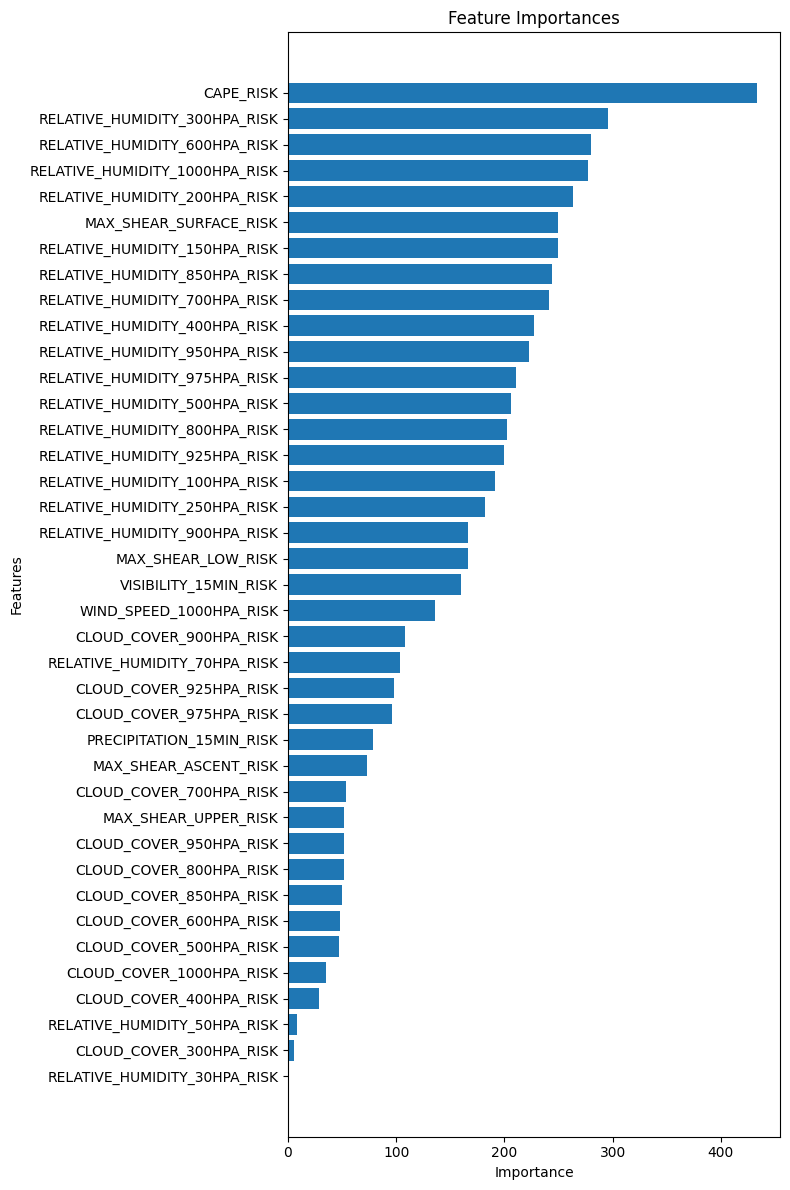


Top 20 Most Important Features:
                           feature  importance
37           VISIBILITY_15MIN_RISK         160
2               MAX_SHEAR_LOW_RISK         166
22   RELATIVE_HUMIDITY_900HPA_RISK         166
30   RELATIVE_HUMIDITY_250HPA_RISK         182
33   RELATIVE_HUMIDITY_100HPA_RISK         191
21   RELATIVE_HUMIDITY_925HPA_RISK         200
24   RELATIVE_HUMIDITY_800HPA_RISK         202
27   RELATIVE_HUMIDITY_500HPA_RISK         206
19   RELATIVE_HUMIDITY_975HPA_RISK         211
20   RELATIVE_HUMIDITY_950HPA_RISK         223
28   RELATIVE_HUMIDITY_400HPA_RISK         227
25   RELATIVE_HUMIDITY_700HPA_RISK         241
23   RELATIVE_HUMIDITY_850HPA_RISK         244
32   RELATIVE_HUMIDITY_150HPA_RISK         250
1           MAX_SHEAR_SURFACE_RISK         250
31   RELATIVE_HUMIDITY_200HPA_RISK         263
18  RELATIVE_HUMIDITY_1000HPA_RISK         277
26   RELATIVE_HUMIDITY_600HPA_RISK         280
29   RELATIVE_HUMIDITY_300HPA_RISK         296
38                       CA

In [113]:
# Get feature importances from the trained model
importances = pd.DataFrame({
    'feature': predictor.feature_names,
    'importance': gb_model.feature_importances_
})

# Sort by importance descending
importances = importances.sort_values('importance', ascending=True)  # Changed to ascending=True for horizontal plot

# Plot feature importances horizontally
plt.figure(figsize=(8,12))  # Swapped width/height
plt.barh(range(len(importances)), importances['importance'])  # Changed to barh
plt.yticks(range(len(importances)), importances['feature'])  # Changed to yticks, removed rotation
plt.ylabel('Features')
plt.xlabel('Importance')  # Swapped labels
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

# Print top 20 most important features
print("\nTop 20 Most Important Features:")
print(importances.tail(20))  # Changed to tail since we sorted ascending


In [114]:
# Print all features used in the model
print("All features used in model:")
for feature in predictor.feature_names:
    print(feature)


All features used in model:
WIND_SPEED_1000HPA_RISK
MAX_SHEAR_SURFACE_RISK
MAX_SHEAR_LOW_RISK
MAX_SHEAR_ASCENT_RISK
MAX_SHEAR_UPPER_RISK
PRECIPITATION_15MIN_RISK
CLOUD_COVER_1000HPA_RISK
CLOUD_COVER_975HPA_RISK
CLOUD_COVER_950HPA_RISK
CLOUD_COVER_925HPA_RISK
CLOUD_COVER_900HPA_RISK
CLOUD_COVER_850HPA_RISK
CLOUD_COVER_800HPA_RISK
CLOUD_COVER_700HPA_RISK
CLOUD_COVER_600HPA_RISK
CLOUD_COVER_500HPA_RISK
CLOUD_COVER_400HPA_RISK
CLOUD_COVER_300HPA_RISK
RELATIVE_HUMIDITY_1000HPA_RISK
RELATIVE_HUMIDITY_975HPA_RISK
RELATIVE_HUMIDITY_950HPA_RISK
RELATIVE_HUMIDITY_925HPA_RISK
RELATIVE_HUMIDITY_900HPA_RISK
RELATIVE_HUMIDITY_850HPA_RISK
RELATIVE_HUMIDITY_800HPA_RISK
RELATIVE_HUMIDITY_700HPA_RISK
RELATIVE_HUMIDITY_600HPA_RISK
RELATIVE_HUMIDITY_500HPA_RISK
RELATIVE_HUMIDITY_400HPA_RISK
RELATIVE_HUMIDITY_300HPA_RISK
RELATIVE_HUMIDITY_250HPA_RISK
RELATIVE_HUMIDITY_200HPA_RISK
RELATIVE_HUMIDITY_150HPA_RISK
RELATIVE_HUMIDITY_100HPA_RISK
RELATIVE_HUMIDITY_70HPA_RISK
RELATIVE_HUMIDITY_50HPA_RISK
RELATIVE_H

In [38]:
# Read the CSV file
test_prediction = pd.read_csv('/Users/kylelyon/Downloads/outpust.csv')

# Add _T-0 suffix to columns that don't already have it
columns = test_prediction.columns.tolist()
test_prediction.columns = [col + '_T-0' if not col.endswith('_T-0') and col != 'Unnamed: 0' else col for col in columns]

test_prediction.head()

,Unnamed: 0,TEMPERATURE_2M_15MIN_T-0,RELATIVE_HUMIDITY_2M_15MIN_T-0,PRECIPITATION_15MIN_T-0,RAIN_15MIN_T-0,WEATHER_CODE_15MIN_T-0,VISIBILITY_15MIN_T-0,IS_DAY_15MIN_T-0,UV_INDEX_T-0,SUNSHINE_DURATION_T-0,CAPE_T-0,LIFTED_INDEX_T-0,CONVECTIVE_INHIBITION_T-0,FREEZING_LEVEL_HEIGHT_T-0,TEMPERATURE_1000HPA_T-0,TEMPERATURE_975HPA_T-0,TEMPERATURE_950HPA_T-0,TEMPERATURE_925HPA_T-0,TEMPERATURE_900HPA_T-0,TEMPERATURE_850HPA_T-0,TEMPERATURE_800HPA_T-0,TEMPERATURE_700HPA_T-0,TEMPERATURE_600HPA_T-0,TEMPERATURE_500HPA_T-0,TEMPERATURE_400HPA_T-0,TEMPERATURE_300HPA_T-0,TEMPERATURE_250HPA_T-0,TEMPERATURE_200HPA_T-0,TEMPERATURE_150HPA_T-0,TEMPERATURE_100HPA_T-0,TEMPERATURE_70HPA_T-0,TEMPERATURE_50HPA_T-0,TEMPERATURE_30HPA_T-0,RELATIVE_HUMIDITY_1000HPA_T-0,RELATIVE_HUMIDITY_975HPA_T-0,RELATIVE_HUMIDITY_950HPA_T-0,RELATIVE_HUMIDITY_925HPA_T-0,RELATIVE_HUMIDITY_900HPA_T-0,RELATIVE_HUMIDITY_850HPA_T-0,RELATIVE_HUMIDITY_800HPA_T-0,RELATIVE_HUMIDITY_700HPA_T-0,RELATIVE_HUMIDITY_600HPA_T-0,RELATIVE_HUMIDITY_500HPA_T-0,RELATIVE_HUMIDITY_400HPA_T-0,RELATIVE_HUMIDITY_300HPA_T-0,RELATIVE_HUMIDITY_250HPA_T-0,RELATIVE_HUMIDITY_200HPA_T-0,RELATIVE_HUMIDITY_150HPA_T-0,RELATIVE_HUMIDITY_100HPA_T-0,RELATIVE_HUMIDITY_70HPA_T-0,RELATIVE_HUMIDITY_50HPA_T-0,RELATIVE_HUMIDITY_30HPA_T-0,CLOUD_COVER_1000HPA_T-0,CLOUD_COVER_975HPA_T-0,CLOUD_COVER_950HPA_T-0,CLOUD_COVER_925HPA_T-0,CLOUD_COVER_900HPA_T-0,CLOUD_COVER_850HPA_T-0,CLOUD_COVER_800HPA_T-0,CLOUD_COVER_700HPA_T-0,CLOUD_COVER_600HPA_T-0,CLOUD_COVER_500HPA_T-0,CLOUD_COVER_400HPA_T-0,CLOUD_COVER_300HPA_T-0,CLOUD_COVER_250HPA_T-0,CLOUD_COVER_200HPA_T-0,CLOUD_COVER_150HPA_T-0,CLOUD_COVER_100HPA_T-0,CLOUD_COVER_70HPA_T-0,CLOUD_COVER_50HPA_T-0,CLOUD_COVER_30HPA_T-0,WIND_SPEED_1000HPA_T-0,WIND_SPEED_975HPA_T-0,WIND_SPEED_950HPA_T-0,WIND_SPEED_925HPA_T-0,WIND_SPEED_900HPA_T-0,WIND_SPEED_850HPA_T-0,WIND_SPEED_800HPA_T-0,WIND_SPEED_700HPA_T-0,WIND_SPEED_600HPA_T-0,WIND_SPEED_500HPA_T-0,WIND_SPEED_400HPA_T-0,WIND_SPEED_300HPA_T-0,WIND_SPEED_250HPA_T-0,WIND_SPEED_200HPA_T-0,WIND_SPEED_150HPA_T-0,WIND_SPEED_100HPA_T-0,WIND_SPEED_70HPA_T-0,WIND_SPEED_50HPA_T-0,WIND_SPEED_30HPA_T-0,WIND_DIRECTION_1000HPA_T-0,WIND_DIRECTION_975HPA_T-0,WIND_DIRECTION_950HPA_T-0,WIND_DIRECTION_925HPA_T-0,WIND_DIRECTION_900HPA_T-0,WIND_DIRECTION_850HPA_T-0,WIND_DIRECTION_800HPA_T-0,WIND_DIRECTION_700HPA_T-0,WIND_DIRECTION_600HPA_T-0,WIND_DIRECTION_500HPA_T-0,WIND_DIRECTION_400HPA_T-0,WIND_DIRECTION_300HPA_T-0,WIND_DIRECTION_250HPA_T-0,WIND_DIRECTION_200HPA_T-0,WIND_DIRECTION_150HPA_T-0,WIND_DIRECTION_100HPA_T-0,WIND_DIRECTION_70HPA_T-0,WIND_DIRECTION_50HPA_T-0,WIND_DIRECTION_30HPA_T-0,MAX_SHEAR_SURFACE_T-0,MAX_SHEAR_LOW_T-0,MAX_SHEAR_ASCENT_T-0,MAX_SHEAR_UPPER_T-0,MAX_CLOUD_COVER_SURFACE_T-0,MAX_CLOUD_COVER_LOW_T-0,MAX_CLOUD_COVER_ASCENT_T-0,MAX_CLOUD_COVER_UPPER_T-0,MAX_WIND_SPEED_SURFACE_T-0,MAX_WIND_SPEED_LOW_T-0,MAX_WIND_SPEED_ASCENT_T-0,MAX_WIND_SPEED_UPPER_T-0,MAX_RELATIVE_HUMIDITY_SURFACE_T-0,MAX_RELATIVE_HUMIDITY_LOW_T-0,MAX_RELATIVE_HUMIDITY_ASCENT_T-0,MAX_RELATIVE_HUMIDITY_UPPER_T-0,MAX_TEMPERATURE_SURFACE_T-0,MAX_TEMPERATURE_LOW_T-0,MAX_TEMPERATURE_ASCENT_T-0,MAX_TEMPERATURE_UPPER_T-0
0,2025-01-16T00:00,50.500,100.00,0.0,0.0,45.0,79199.477,0.00,0.00,0.0,0.0,14.2,0.0,11220.473,51.6,53.1,54.5,53.7,54.8,53.7,50.2,36.4,21.4,7.2,-12.1,-31.0,-46.3,-65.2,-72.4,-99.4,-99.4,-91.3,-69.7,100,94,89,77,40,14,20,73,68,57,8,8,31,22,3,10,7,4,0,100,35,15,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0.9,2.7,5.6,6.3,9.7,9.2,10.1,12.8,26.4,55.1,86.1,127.4,148.6,148.5,120.1,93.6,38.4,15.1,8.2,346,75,85,97,117,146,252,249,245,230,229,237,239,236,239,251,241,250,275,18.917175,30.846358,21.904291,16.720913,100,5,5,0,9.7,12.8,127.4,148.6,100,73,73,31,54.8,54.8,36.4,-31.0
1,2025-01-16T01:00,50.450,100.00,0.0,0.0,45.0,79199.477,0.25,0.00,0.0,0.0,14.5,0.0,11056.431,51.4,53.1,54.7,54.8,55.6,53.5,49.5,35.3,20.4,6.4,-11.5,-31.0,-45.4,-64.3,-72.4,-98.5,-99.4,-91.3,-70.6,100,94,88,65,34,14,24,83,82,66,25,8,27,20,3,10,7,4,0,100,32,11,0,0,0,0,25,24,0,0,0,0,0,0,0,0,0,0,1.5,1.9,5.1,6.8,10

In [40]:
import pickle

In [41]:
# If you want to save everything needed to recreate the model:
model_package = {
    'predictor': predictor,
    'processed_df': processed_df,
    'flat_thresholds': flat_thresholds,
    'invert_map': invert_map
}

with open('lcc_model_package_v2.pkl', 'wb') as f:
    pickle.dump(model_package, f)

# 6) Predict on new raw data
row_index = 0  # Can change this to select different rows
df_new = test_prediction.iloc[[row_index]][['CLOUD_COVER_1000HPA_T-0', 'CLOUD_COVER_975HPA_T-0', 
    'CLOUD_COVER_950HPA_T-0', 'CLOUD_COVER_925HPA_T-0', 'CLOUD_COVER_900HPA_T-0',
    'CLOUD_COVER_850HPA_T-0', 'CLOUD_COVER_800HPA_T-0', 'CLOUD_COVER_700HPA_T-0',
    'CLOUD_COVER_600HPA_T-0', 'CLOUD_COVER_500HPA_T-0', 'CLOUD_COVER_400HPA_T-0',
    'CLOUD_COVER_300HPA_T-0', 'WIND_SPEED_1000HPA_T-0', 'MAX_SHEAR_SURFACE_T-0',
    'MAX_SHEAR_LOW_T-0', 'MAX_SHEAR_ASCENT_T-0', 'MAX_SHEAR_UPPER_T-0',
    'PRECIPITATION_15MIN_T-0', 'RELATIVE_HUMIDITY_1000HPA_T-0', 'RELATIVE_HUMIDITY_975HPA_T-0',
    'RELATIVE_HUMIDITY_950HPA_T-0', 'RELATIVE_HUMIDITY_925HPA_T-0', 'RELATIVE_HUMIDITY_900HPA_T-0',
    'RELATIVE_HUMIDITY_850HPA_T-0', 'RELATIVE_HUMIDITY_800HPA_T-0', 'RELATIVE_HUMIDITY_700HPA_T-0',
    'RELATIVE_HUMIDITY_600HPA_T-0', 'RELATIVE_HUMIDITY_500HPA_T-0', 'RELATIVE_HUMIDITY_400HPA_T-0',
    'RELATIVE_HUMIDITY_300HPA_T-0', 'RELATIVE_HUMIDITY_250HPA_T-0', 'RELATIVE_HUMIDITY_200HPA_T-0',
    'RELATIVE_HUMIDITY_150HPA_T-0', 'RELATIVE_HUMIDITY_100HPA_T-0', 'RELATIVE_HUMIDITY_70HPA_T-0',
    'RELATIVE_HUMIDITY_50HPA_T-0', 'RELATIVE_HUMIDITY_30HPA_T-0', 'CAPE_T-0',
    'WEATHER_CODE_15MIN_T-0', 'VISIBILITY_15MIN_T-0']]

print("Predicting on new sample...")

pred_class = predictor.predict(df_new)
pred_proba = predictor.predict_proba(df_new)
print(f"Predicted class: {pred_class}, Probabilities: {pred_proba}")

Predicting on new sample...

Preparing prediction...
Applying risk transformations...

Original columns:
['CLOUD_COVER_1000HPA_T-0', 'CLOUD_COVER_975HPA_T-0', 'CLOUD_COVER_950HPA_T-0', 'CLOUD_COVER_925HPA_T-0', 'CLOUD_COVER_900HPA_T-0', 'CLOUD_COVER_850HPA_T-0', 'CLOUD_COVER_800HPA_T-0', 'CLOUD_COVER_700HPA_T-0', 'CLOUD_COVER_600HPA_T-0', 'CLOUD_COVER_500HPA_T-0', 'CLOUD_COVER_400HPA_T-0', 'CLOUD_COVER_300HPA_T-0', 'WIND_SPEED_1000HPA_T-0', 'MAX_SHEAR_SURFACE_T-0', 'MAX_SHEAR_LOW_T-0', 'MAX_SHEAR_ASCENT_T-0', 'MAX_SHEAR_UPPER_T-0', 'PRECIPITATION_15MIN_T-0', 'RELATIVE_HUMIDITY_1000HPA_T-0', 'RELATIVE_HUMIDITY_975HPA_T-0', 'RELATIVE_HUMIDITY_950HPA_T-0', 'RELATIVE_HUMIDITY_925HPA_T-0', 'RELATIVE_HUMIDITY_900HPA_T-0', 'RELATIVE_HUMIDITY_850HPA_T-0', 'RELATIVE_HUMIDITY_800HPA_T-0', 'RELATIVE_HUMIDITY_700HPA_T-0', 'RELATIVE_HUMIDITY_600HPA_T-0', 'RELATIVE_HUMIDITY_500HPA_T-0', 'RELATIVE_HUMIDITY_400HPA_T-0', 'RELATIVE_HUMIDITY_300HPA_T-0', 'RELATIVE_HUMIDITY_250HPA_T-0', 'RELATIVE_HUMIDITY

In [ ]:
import pickle

# After training, save the entire predictor instance
with open('lcc_model_v2.pkl', 'wb') as f:
    pickle.dump(predictor, f)

# 6) Predict on new raw data
row_index = 0  # Can change this to select different rows
df_new = test_prediction.iloc[[row_index]][['CLOUD_COVER_1000HPA_T-0', 'CLOUD_COVER_975HPA_T-0', 
    'CLOUD_COVER_950HPA_T-0', 'CLOUD_COVER_925HPA_T-0', 'CLOUD_COVER_900HPA_T-0',
    'CLOUD_COVER_850HPA_T-0', 'CLOUD_COVER_800HPA_T-0', 'CLOUD_COVER_700HPA_T-0',
    'CLOUD_COVER_600HPA_T-0', 'CLOUD_COVER_500HPA_T-0', 'CLOUD_COVER_400HPA_T-0',
    'CLOUD_COVER_300HPA_T-0', 'WIND_SPEED_1000HPA_T-0', 'MAX_SHEAR_SURFACE_T-0',
    'MAX_SHEAR_LOW_T-0', 'MAX_SHEAR_ASCENT_T-0', 'MAX_SHEAR_UPPER_T-0',
    'PRECIPITATION_15MIN_T-0', 'RELATIVE_HUMIDITY_1000HPA_T-0', 'RELATIVE_HUMIDITY_975HPA_T-0',
    'RELATIVE_HUMIDITY_950HPA_T-0', 'RELATIVE_HUMIDITY_925HPA_T-0', 'RELATIVE_HUMIDITY_900HPA_T-0',
    'RELATIVE_HUMIDITY_850HPA_T-0', 'RELATIVE_HUMIDITY_800HPA_T-0', 'RELATIVE_HUMIDITY_700HPA_T-0',
    'RELATIVE_HUMIDITY_600HPA_T-0', 'RELATIVE_HUMIDITY_500HPA_T-0', 'RELATIVE_HUMIDITY_400HPA_T-0',
    'RELATIVE_HUMIDITY_300HPA_T-0', 'RELATIVE_HUMIDITY_250HPA_T-0', 'RELATIVE_HUMIDITY_200HPA_T-0',
    'RELATIVE_HUMIDITY_150HPA_T-0', 'RELATIVE_HUMIDITY_100HPA_T-0', 'RELATIVE_HUMIDITY_70HPA_T-0',
    'RELATIVE_HUMIDITY_50HPA_T-0', 'RELATIVE_HUMIDITY_30HPA_T-0', 'CAPE_T-0',
    'WEATHER_CODE_15MIN_T-0', 'VISIBILITY_15MIN_T-0']]

print("Predicting on new sample...")

pred_class = predictor.predict(df_new)
pred_proba = predictor.predict_proba(df_new)
print(f"Predicted class: {pred_class}, Probabilities: {pred_proba}")

### Modeling

In [16]:
model_features = temperature_features + wind_speed_features + wind_shear_features + precipitation_features + cloud_cover_features + humidity_features + convective_features + surface_features + ['NOGO']

In [18]:
model_data = all_data_samples_unique[model_features].drop(columns=[
    'FIELD_MILL_MAX', 'FIELD_MILL_MEDIAN',
    'SUNSHINE_DURATION', 'CAPE'
])

In [19]:
def flatten_data(data):
    """
    Flattens time series data from launch history into separate columns for each timestep.

    Parameters:
    - launches_with_history (pd.DataFrame): Input dataset with launch history and time series data

    Returns:
    - pd.DataFrame: Flattened dataset with time-lagged features and hourly averages
    """
    flattened_data = pd.DataFrame()

    # Process each row in launches_with_history 
    for idx, row in data.iterrows():
        flat_row = {}

        # Copy over NOGO column directly
        if 'NOGO' in row.index:
            flat_row['NOGO'] = row['NOGO']

        # Process time series columns
        for col in row.index:
            if col == 'NOGO':
                continue

            if isinstance(row[col], list):
                if col == 'WEATHER_CODE_15MIN':
                    # For WEATHER_CODE_15MIN, calculate hourly modes
                    values = row[col]
                    try:
                        # If the values are stored as a string, evaluate them
                        if isinstance(values, str):
                            values = eval(values)

                        # Ensure we have enough values or pad with None
                        while len(values) < 12:  # 4 values/hour * 3 hours
                            values.append(None)

                        # Calculate hourly modes, handling None values
                        for i in range(3):
                            start_idx = i * 4
                            end_idx = start_idx + 4
                            hour_values = [v for v in values[start_idx:end_idx] if v is not None]
                            if hour_values:
                                from statistics import mode
                                hour_mode = mode(hour_values)
                            else:
                                hour_mode = None
                            flat_row[f"{col}_T-{2-i}"] = hour_mode
                    except Exception as e:
                        print(f"Error processing column {col}: {e}")
                        # Set all three time points to None if there's an error
                        for i in range(3):
                            flat_row[f"{col}_T-{2-i}"] = None
                elif '_15MIN' in col:
                    # For other 15MIN columns, calculate hourly averages
                    values = row[col]
                    try:
                        # If the values are stored as a string, evaluate them
                        if isinstance(values, str):
                            values = eval(values)

                        # Ensure we have enough values or pad with None
                        while len(values) < 12:  # 4 values/hour * 3 hours
                            values.append(None)

                        # Calculate hourly averages, handling None values
                        for i in range(3):
                            start_idx = i * 4
                            end_idx = start_idx + 4
                            hour_values = [v for v in values[start_idx:end_idx] if v is not None]
                            if hour_values:
                                hour_avg = sum(hour_values) / len(hour_values)
                            else:
                                hour_avg = None
                            flat_row[f"{col}_T-{2-i}"] = hour_avg
                    except Exception as e:
                        print(f"Error processing column {col}: {e}")
                        # Set all three time points to None if there's an error
                        for i in range(3):
                            flat_row[f"{col}_T-{2-i}"] = None
                else:
                    # For regular time series, create separate columns for each timestep
                    values = row[col]
                    if len(values) >= 3:
                        for i in range(3):
                            flat_row[f"{col}_T-{2-i}"] = values[i]

        # Append the flattened row
        flattened_data = pd.concat([flattened_data, pd.DataFrame([flat_row])], ignore_index=True)

    return flattened_data

# Usage:
flattened_model_data = flatten_data(model_data)

In [20]:
def create_aggregated_features(df, categories):
    """
    Aggregates T-0 features across given pressure levels by category.

    Parameters
    ----------
    df : pd.DataFrame
        The original dataframe containing columns like TEMPERATURE_1000HPA_T-0, WIND_SPEED_1000HPA_T-0, etc.
    categories : dict
        Dictionary mapping category names (e.g. 'SURFACE') to lists of tuples (pressure_str, approx_height).
        Example:
        {
            'SURFACE': [
                ('1000HPA', 110),
                ('975HPA', 320),
                ('950HPA', 540),
                ('925HPA', 760),
                ('900HPA', 990)
            ],
            'LOW': [
                ('900HPA', 990),
                ('850HPA', 1500),
                ('800HPA', 2000),
                ('700HPA', 3000)
            ],
            'ASCENT': [
                ('700HPA', 3000),
                ('600HPA', 4200),
                ('500HPA', 5600),
                ('400HPA', 7200),
                ('300HPA', 9200)
            ],
            'UPPER': [
                ('300HPA', 9200),
                ('250HPA', 10500),
                ('200HPA', 12000),
                ('150HPA', 13800),
                ('100HPA', 16000)
            ]
        }

    Returns
    -------
    pd.DataFrame
        The original dataframe with additional aggregated features appended.
    """
    # Identify all T-0 columns
    t0_columns = [col for col in df.columns if col.endswith('_T-0')]
    
    # Extract variable names and pressure levels from columns
    # Columns are typically named like "TEMPERATURE_1000HPA_T-0"
    # We'll parse them into (variable, pressure, 'T-0')
    # Example: "TEMPERATURE_1000HPA_T-0" -> variable="TEMPERATURE", pressure="1000HPA"
    # We'll store them to group by variable and category later.
    parsed = []
    for col in t0_columns:
        parts = col.split('_')
        # Typically format: VARIABLE_PRESSURELEVEL_T-0
        # For example: TEMPERATURE_1000HPA_T-0
        # The last element is 'T-0', the second-last might be something like '1000HPA', 
        # The rest forms the variable name (if multiple underscores in the variable name, join them)
        
        # We know T-0 is always last:
        time_part = parts[-1]  # "T-0"
        pressure_part = parts[-2]  # e.g. "1000HPA"
        # Everything before that is variable name:
        variable_name = "_".join(parts[:-2])  # might be "TEMPERATURE"
        
        parsed.append((col, variable_name, pressure_part))
    
    # For convenience, let's map pressure levels to categories:
    pressure_to_category = {}
    for category, levels in categories.items():
        for (level_str, _) in levels:
            pressure_to_category[level_str] = category
    
    # Group columns by variable and category:
    from collections import defaultdict
    var_cat_cols = defaultdict(list)
    
    for col, var, press in parsed:
        if press in pressure_to_category:
            cat = pressure_to_category[press]
            var_cat_cols[(var, cat)].append(col)
    
    # Now, for each (variable, category) group, we aggregate by taking the max:
    for (var, cat), cols in var_cat_cols.items():
        # Create a new feature column, for example: MAX_TEMPERATURE_SURFACE_T0
        new_col = f"MAX_{var}_{cat}_T0"
        df[new_col] = df[cols].max(axis=1)
        
    return df

# Usage:
categories = {
    'SURFACE': [
        ('1000HPA', 110),
        ('975HPA', 320),
        ('950HPA', 540),
        ('925HPA', 760),
        ('900HPA', 990),
    ],
    'LOW': [
        ('900HPA', 990),
        ('850HPA', 1500),
        ('800HPA', 2000),
        ('700HPA', 3000),
    ],
    'ASCENT': [
        ('700HPA', 3000),
        ('600HPA', 4200),
        ('500HPA', 5600),
        ('400HPA', 7200),
        ('300HPA', 9200),
    ],
    'UPPER': [
        ('300HPA', 9200),
        ('250HPA', 10500),
        ('200HPA', 12000),
        ('150HPA', 13800),
        ('100HPA', 16000),
    ]
}

# Call the function:
flattened_agg_model_data = create_aggregated_features(flattened_model_data, categories)

In [21]:
flattened_agg_model_data.drop([col for col in flattened_agg_model_data.columns if 'T-2' in col or 'T-1' in col or 'HPA' in col], axis=1, inplace=True)

In [22]:
# Move NOGO column to end by dropping and re-adding it
nogo_col = flattened_agg_model_data['NOGO']
flattened_agg_model_data = flattened_agg_model_data.drop('NOGO', axis=1)
flattened_agg_model_data['NOGO'] = nogo_col

In [68]:
print(flattened_agg_model_data.describe().to_markdown())

|       |   MAX_SHEAR_SURFACE_T-0 |   MAX_SHEAR_LOW_T-0 |   MAX_SHEAR_ASCENT_T-0 |   MAX_SHEAR_UPPER_T-0 |   PRECIPITATION_15MIN_T-0 |   RAIN_15MIN_T-0 |   FREEZING_LEVEL_HEIGHT_T-0 |   LIFTED_INDEX_T-0 |   CONVECTIVE_INHIBITION_T-0 |   CAPE_15MIN_T-0 |   UV_INDEX_T-0 |   WEATHER_CODE_15MIN_T-0 |   VISIBILITY_15MIN_T-0 |   MAX_TEMPERATURE_SURFACE_T0 |   MAX_TEMPERATURE_LOW_T0 |   MAX_TEMPERATURE_ASCENT_T0 |   MAX_TEMPERATURE_UPPER_T0 |   MAX_WIND_SPEED_SURFACE_T0 |   MAX_WIND_SPEED_LOW_T0 |   MAX_WIND_SPEED_ASCENT_T0 |   MAX_WIND_SPEED_UPPER_T0 |   MAX_CLOUD_COVER_SURFACE_T0 |   MAX_CLOUD_COVER_LOW_T0 |   MAX_CLOUD_COVER_ASCENT_T0 |   MAX_CLOUD_COVER_UPPER_T0 |   MAX_RELATIVE_HUMIDITY_SURFACE_T0 |   MAX_RELATIVE_HUMIDITY_LOW_T0 |   MAX_RELATIVE_HUMIDITY_ASCENT_T0 |   MAX_RELATIVE_HUMIDITY_UPPER_T0 |         NOGO |
|:------|------------------------:|--------------------:|-----------------------:|----------------------:|--------------------------:|-----------------:|---------------------

#### Imports

In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from lightgbm import LGBMClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [92]:
class GradientBoostingPredictor:
    def __init__(self, flat_data, target_column):
        self.flat_data = flat_data
        self.target_column = target_column
        self.gb_model = None
        self.scaler = MinMaxScaler()
        self.X_test = None  # Added to store test set
        self.y_test = None  # Added to store test set
        self.feature_names = None  # Added to store feature names

    def train(self):
        """Train gradient boosting model using flattened data"""
        print("Preparing data for gradient boosting model...")
        # Prepare data
        X = self.flat_data.drop(columns=[self.target_column])
        # Only keep T-0 columns
        X = X[[col for col in X.columns if 'T-0' in col or not any(f'T-{i}' in col for i in range(3))]]
        y = self.flat_data[self.target_column]

        # Add a binary visibility threshold feature while keeping the original
        # visibility_col = 'VISIBILITY_15MIN_T-0'
        # if visibility_col in X.columns:
        #     # Keep original visibility
            # Add new binary feature for threshold
            # X['VISIBILITY_THRESHOLD_MET_T-0'] = (X[visibility_col] >= 6437.38).astype(float)

        # Store feature names
        self.feature_names = X.columns.tolist()
        print("Feature names:", self.feature_names)

        print(f"Total features being used: {len(X.columns)}")

        print("Splitting data into train and test sets...")
        # Train-test split
        X_train, self.X_test, y_train, self.y_test = train_test_split(
            X, y, 
            test_size=0.2, 
            random_state=42
        )

        # Scale the features
        print("Scaling features...")
        X_train = self.scaler.fit_transform(X_train)
        self.X_test = self.scaler.transform(self.X_test)

        print(f"Training set size: {len(X_train)}, Test set size: {len(self.X_test)}")

        print("Setting up monotonic constraints...")
        # Define monotonic constraints
        # 1: increasing, -1: decreasing, 0: no constraint
        monotonic_constraints = {
            # Cloud Cover: More cloud cover -> higher risk (1)
            'MAX_CLOUD_COVER_SURFACE_T0': 1,
            'MAX_CLOUD_COVER_LOW_T0': 1,
            'MAX_CLOUD_COVER_ASCENT_T0': 1,
            'MAX_CLOUD_COVER_UPPER_T0': 1,

            # Relative Humidity: Higher humidity -> higher risk (1)
            'MAX_RELATIVE_HUMIDITY_SURFACE_T0': 1,
            'MAX_RELATIVE_HUMIDITY_LOW_T0': 1,
            'MAX_RELATIVE_HUMIDITY_ASCENT_T0': 1,
            'MAX_RELATIVE_HUMIDITY_UPPER_T0': 1,

            # Temperature: Non-monotonic relationship
            'MAX_TEMPERATURE_SURFACE_T0': 0,
            'MAX_TEMPERATURE_LOW_T0': 0,
            'MAX_TEMPERATURE_ASCENT_T0': 0,
            'MAX_TEMPERATURE_UPPER_T0': 0,

            # Wind Speed: Higher wind speed -> higher risk (1)
            'MAX_WIND_SPEED_SURFACE_T0': 1,
            'MAX_WIND_SPEED_LOW_T0': 1,
            'MAX_WIND_SPEED_ASCENT_T0': 1,
            'MAX_WIND_SPEED_UPPER_T0': 1,

            # Visibility and Weather
            'VISIBILITY_15MIN_T-0': -1,
            'VISIBILITY_THRESHOLD_MET_T-0': -1,   # Meeting threshold -> lower risk
            'WEATHER_CODE_15MIN_T-0': 0,

            # Solar/Radiation
            'UV_INDEX_T-0': 0,

            # CAPE and Stability Indices
            'CAPE_15MIN_T-0': 1,
            'CONVECTIVE_INHIBITION_T-0': -1,
            'LIFTED_INDEX_T-0': -1,

            # Shear
            'MAX_SHEAR_SURFACE_T-0': 1,
            'MAX_SHEAR_LOW_T-0': 1,
            'MAX_SHEAR_ASCENT_T-0': 1,
            'MAX_SHEAR_UPPER_T-0': 1,

            # Freezing Level and Precipitation
            'FREEZING_LEVEL_HEIGHT_T-0': 1,
            'PRECIPITATION_15MIN_T-0': 1,
            'RAIN_15MIN_T-0': 1
        }

        print("Creating feature names and constraints lists...")
        # Create feature names list and constraints list
        monotone_constraints = [monotonic_constraints.get(col, 0) 
                              for col in self.feature_names]

        print("Setting up model with known best parameters...")
        # Use known best parameters directly
        self.gb_model = LGBMClassifier(
            objective='binary',
            random_state=42,
            n_jobs=-1,
            boosting_type='gbdt',
            subsample=0.8,
            colsample_bytree=0.8,
            learning_rate=0.1,
            max_depth=7,
            min_child_samples=20,
            n_estimators=300,
            num_leaves=63,
            reg_alpha=0.01,
            reg_lambda=1.0,
            seed=42  # Added seed for reproducibility
        )

        print("Fitting model...")
        self.gb_model.fit(X_train, y_train)
        print("Model training complete!")

        # Evaluate on test set
        test_score = self.gb_model.score(self.X_test, self.y_test)
        print(f"Test set accuracy: {test_score:.4f}")

        # Get feature importances
        importances = pd.DataFrame({
            'feature': self.feature_names,
            'importance': self.gb_model.feature_importances_
        })
        importances = importances.sort_values('importance', ascending=False)
        print("\nFeature Importances:")
        print(importances.to_string(index=False))

        return self.gb_model

    def predict(self, new_data):
        """
        Make predictions on new data.

        Args:
            new_data (pd.DataFrame): New data to predict on. Should have the same features 
                                   as training data (except target column).

        Returns:
            numpy.ndarray: Predicted probabilities
        """
        # Ensure all required features are present
        missing_features = set(self.feature_names) - set(new_data.columns)
        if missing_features:
            raise ValueError(f"Missing features in new data: {missing_features}")

        # Reorder columns to match training data
        X = new_data[self.feature_names]

        # Scale the features using the same scaler used during training
        X_scaled = self.scaler.transform(X)

        # Make predictions
        return self.gb_model.predict(X_scaled)

    def predict_proba(self, new_data):
        """
        Make probability predictions on new data.

        Args:
            new_data (pd.DataFrame): New data to predict on. Should have the same features 
                                   as training data (except target column).

        Returns:
            numpy.ndarray: Predicted probabilities for each class
        """
        # Ensure all required features are present
        missing_features = set(self.feature_names) - set(new_data.columns)
        if missing_features:
            raise ValueError(f"Missing features in new data: {missing_features}")

        # Reorder columns to match training data
        X = new_data[self.feature_names]

        # Scale the features using the same scaler used during training
        X_scaled = self.scaler.transform(X)

        # Make probability predictions
        return self.gb_model.predict_proba(X_scaled)

# Usage example:
gb_predictor = GradientBoostingPredictor(
    flat_data=flattened_agg_model_data,
    target_column='NOGO'
)

# Train gradient boosting model
gb_model = gb_predictor.train()

# Generate predictions on held-out test set
y_pred = gb_model.predict(gb_predictor.X_test)
y_test = gb_predictor.y_test

# Calculate and print various classification metrics
print("\nDetailed Classification Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

# Generate and print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print("                  Predicted Negative  Predicted Positive")
print(f"Actual Negative       {conf_matrix[0][0]}                {conf_matrix[0][1]}")
print(f"Actual Positive       {conf_matrix[1][0]}                {conf_matrix[1][1]}")

# Calculate additional metrics
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
npv = tn / (tn + fn)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print("\nAdditional Metrics:")
print(f"Specificity (True Negative Rate): {specificity:.4f}")
print(f"Negative Predictive Value: {npv:.4f}")
print(f"False Positive Rate: {fpr:.4f}")
print(f"False Negative Rate: {fnr:.4f}")


Preparing data for gradient boosting model...
Feature names: ['MAX_SHEAR_SURFACE_T-0', 'MAX_SHEAR_LOW_T-0', 'MAX_SHEAR_ASCENT_T-0', 'MAX_SHEAR_UPPER_T-0', 'PRECIPITATION_15MIN_T-0', 'RAIN_15MIN_T-0', 'FREEZING_LEVEL_HEIGHT_T-0', 'LIFTED_INDEX_T-0', 'CONVECTIVE_INHIBITION_T-0', 'CAPE_15MIN_T-0', 'UV_INDEX_T-0', 'WEATHER_CODE_15MIN_T-0', 'VISIBILITY_15MIN_T-0', 'MAX_TEMPERATURE_SURFACE_T0', 'MAX_TEMPERATURE_LOW_T0', 'MAX_TEMPERATURE_ASCENT_T0', 'MAX_TEMPERATURE_UPPER_T0', 'MAX_WIND_SPEED_SURFACE_T0', 'MAX_WIND_SPEED_LOW_T0', 'MAX_WIND_SPEED_ASCENT_T0', 'MAX_WIND_SPEED_UPPER_T0', 'MAX_CLOUD_COVER_SURFACE_T0', 'MAX_CLOUD_COVER_LOW_T0', 'MAX_CLOUD_COVER_ASCENT_T0', 'MAX_CLOUD_COVER_UPPER_T0', 'MAX_RELATIVE_HUMIDITY_SURFACE_T0', 'MAX_RELATIVE_HUMIDITY_LOW_T0', 'MAX_RELATIVE_HUMIDITY_ASCENT_T0', 'MAX_RELATIVE_HUMIDITY_UPPER_T0']
Total features being used: 29
Splitting data into train and test sets...
Scaling features...
Training set size: 15405, Test set size: 3852
Setting up monotonic constr

In [98]:
import pickle
import numpy as np
import pandas as pd
import shap
from typing import Dict, Tuple, Any
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMClassifier

class GradientBoostingPredictor:
    def __init__(self, flat_data, target_column):
        self.flat_data = flat_data
        self.target_column = target_column
        self.gb_model = None
        self.scaler = MinMaxScaler()
        self.X_test = None
        self.y_test = None
        self.feature_names = None

    def train(self):
        print("Preparing data for gradient boosting model...")
        X = self.flat_data.drop(columns=[self.target_column])
        X = X[[col for col in X.columns if 'T-0' in col or not any(f'T-{i}' in col for i in range(3))]]
        y = self.flat_data[self.target_column]

        self.feature_names = X.columns.tolist()
        print("Feature names:", self.feature_names)

        X_train, self.X_test, y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        X_train = self.scaler.fit_transform(X_train)
        self.X_test = self.scaler.transform(self.X_test)

        self.gb_model = LGBMClassifier(
            objective='binary',
            random_state=42,
            n_jobs=-1,
            boosting_type='gbdt',
            subsample=0.8,
            colsample_bytree=0.8,
            learning_rate=0.1,
            max_depth=7,
            min_child_samples=20,
            n_estimators=300,
            num_leaves=63,
            reg_alpha=0.01,
            reg_lambda=1.0,
            seed=42
        )

        self.gb_model.fit(X_train, y_train)
        print("Model training complete!")

        return self.gb_model

    def predict_proba(self, new_data):
        missing_features = set(self.feature_names) - set(new_data.columns)
        if missing_features:
            raise ValueError(f"Missing features in new data: {missing_features}")

        X = new_data[self.feature_names]
        X_scaled = self.scaler.transform(X)
        return self.gb_model.predict_proba(X_scaled)

class LaunchPredictor:
    def __init__(self, model_path: str):
        print(f"Loading predictor from {model_path}")
        with open(model_path, 'rb') as f:
            self.predictor = pickle.load(f)
        self.explainer = None

    def initialize_explainer(self):
        if self.explainer is None:
            model = self.predictor.gb_model
            print(f"Initializing SHAP explainer with model type: {type(model)}")
            self.explainer = shap.TreeExplainer(model)

    def predict(self, features: Dict[str, float]) -> Tuple[bool, float, Dict[str, Any]]:
        print("\n=== New Prediction ===")
        print("Input features:", features)
        
        df = pd.DataFrame([features])
        
        try:
            pred_proba = self.predictor.predict_proba(df)[0]
            print("Prediction probabilities obtained successfully")
        except Exception as e:
            print(f"Error getting prediction probabilities: {str(e)}")
            raise
            
        go_confidence = pred_proba[0]
        decision = go_confidence >= 0.5
        
        print(f"Prediction: {'GO' if decision else 'NOGO'}, GO Confidence: {go_confidence*100:.4f}%")
        print("Raw probabilities: GO={:.4f}, NOGO={:.4f}".format(pred_proba[0], pred_proba[1]))
        
        try:
            self.initialize_explainer()
            X_scaled = self.predictor.scaler.transform(df)
            shap_values = self.explainer.shap_values(X_scaled)
            if isinstance(shap_values, list):
                shap_values = shap_values[0]
            print("SHAP values calculated successfully")
        except Exception as e:
            print(f"Error calculating SHAP values: {str(e)}")
            raise
        
        result = {
            'prediction': 'GO' if decision else 'NOGO',
            'confidence': go_confidence,
            'raw_probabilities': pred_proba,
            'input_features': df.to_dict('records')[0],
            'shap_values': shap_values,
            'feature_importance': self._get_feature_importance(df, shap_values)
        }
        
        return decision, go_confidence, result
    
    def _get_feature_importance(self, X: pd.DataFrame, shap_values: np.ndarray) -> Dict[str, float]:
        return dict(zip(X.columns, np.abs(shap_values).mean(0)))

# Example usage:
# Train the model
gb_predictor = GradientBoostingPredictor(flat_data=flattened_agg_model_data, target_column='NOGO')
gb_model = gb_predictor.train()

# Save the model
with open('models/gb_predictor.pkl', 'wb') as f:
    pickle.dump(gb_predictor, f)

# Load and use the model
launch_predictor = LaunchPredictor('models/gb_predictor.pkl')

Preparing data for gradient boosting model...
Feature names: ['MAX_SHEAR_SURFACE_T-0', 'MAX_SHEAR_LOW_T-0', 'MAX_SHEAR_ASCENT_T-0', 'MAX_SHEAR_UPPER_T-0', 'PRECIPITATION_15MIN_T-0', 'RAIN_15MIN_T-0', 'FREEZING_LEVEL_HEIGHT_T-0', 'LIFTED_INDEX_T-0', 'CONVECTIVE_INHIBITION_T-0', 'CAPE_15MIN_T-0', 'UV_INDEX_T-0', 'WEATHER_CODE_15MIN_T-0', 'VISIBILITY_15MIN_T-0', 'MAX_TEMPERATURE_SURFACE_T0', 'MAX_TEMPERATURE_LOW_T0', 'MAX_TEMPERATURE_ASCENT_T0', 'MAX_TEMPERATURE_UPPER_T0', 'MAX_WIND_SPEED_SURFACE_T0', 'MAX_WIND_SPEED_LOW_T0', 'MAX_WIND_SPEED_ASCENT_T0', 'MAX_WIND_SPEED_UPPER_T0', 'MAX_CLOUD_COVER_SURFACE_T0', 'MAX_CLOUD_COVER_LOW_T0', 'MAX_CLOUD_COVER_ASCENT_T0', 'MAX_CLOUD_COVER_UPPER_T0', 'MAX_RELATIVE_HUMIDITY_SURFACE_T0', 'MAX_RELATIVE_HUMIDITY_LOW_T0', 'MAX_RELATIVE_HUMIDITY_ASCENT_T0', 'MAX_RELATIVE_HUMIDITY_UPPER_T0']
[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42
[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Cur

In [99]:
flattened_agg_model_data.to_csv("model_data.csv", index=False)

[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42
[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42

Prediction Results for Violation Sample:
Predicted Class: GO
Probability of GO: 0.9939
Probability of NOGO: 0.0061

Feature Importance Analysis:

Top 10 Most Important Features:
MAX_WIND_SPEED_ASCENT_T0: 1.5370
MAX_SHEAR_ASCENT_T-0: 0.9095
MAX_SHEAR_SURFACE_T-0: 0.6448
MAX_RELATIVE_HUMIDITY_LOW_T0: 0.5772
FREEZING_LEVEL_HEIGHT_T-0: 0.5490
MAX_WIND_SPEED_LOW_T0: 0.5298
MAX_SHEAR_UPPER_T-0: 0.5082
MAX_RELATIVE_HUMIDITY_ASCENT_T0: 0.4217
VISIBILITY_15MIN_T-0: 0.4142
MAX_RELATIVE_HUMIDITY_SURFACE_T0: 0.3906

Detailed Prediction Explanation:


/Users/kylelyon/Git/sdataplab/data/venv/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


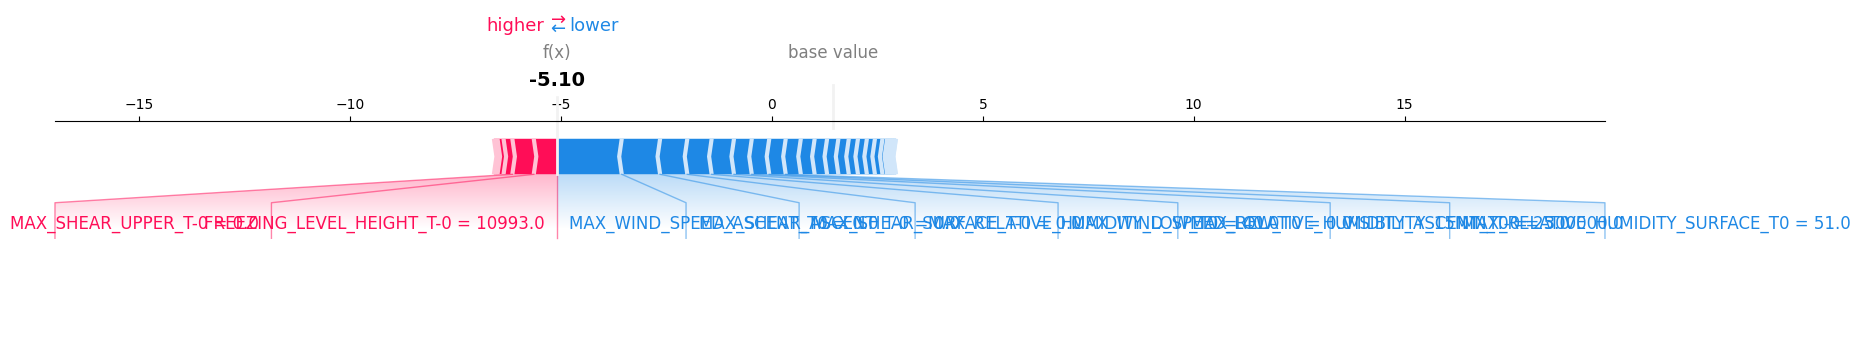

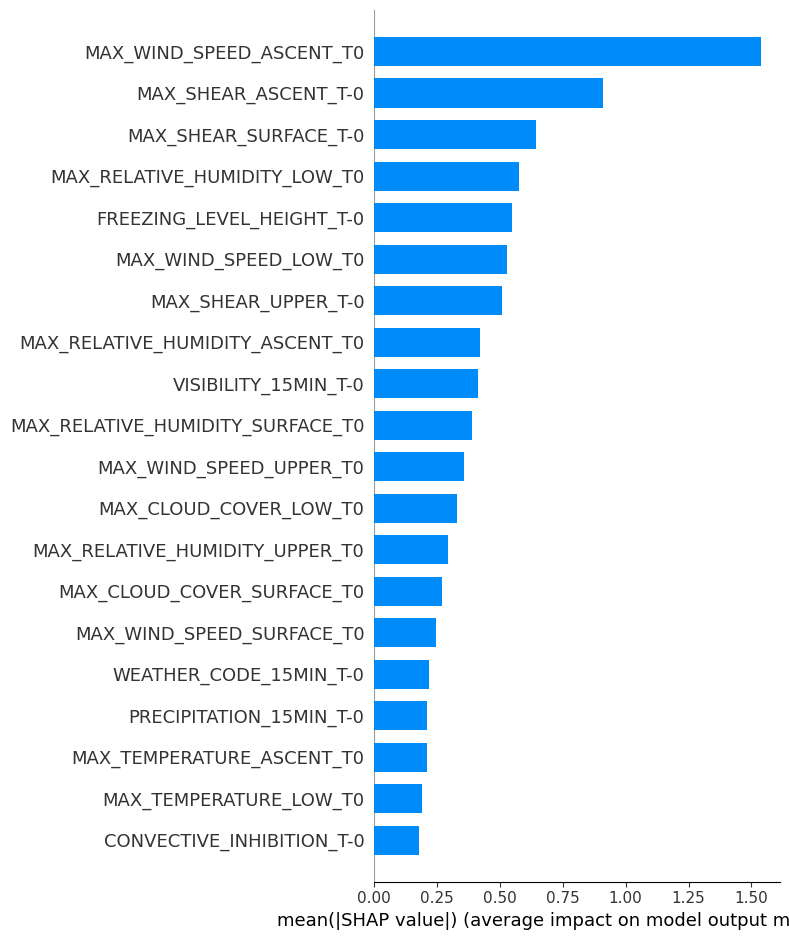

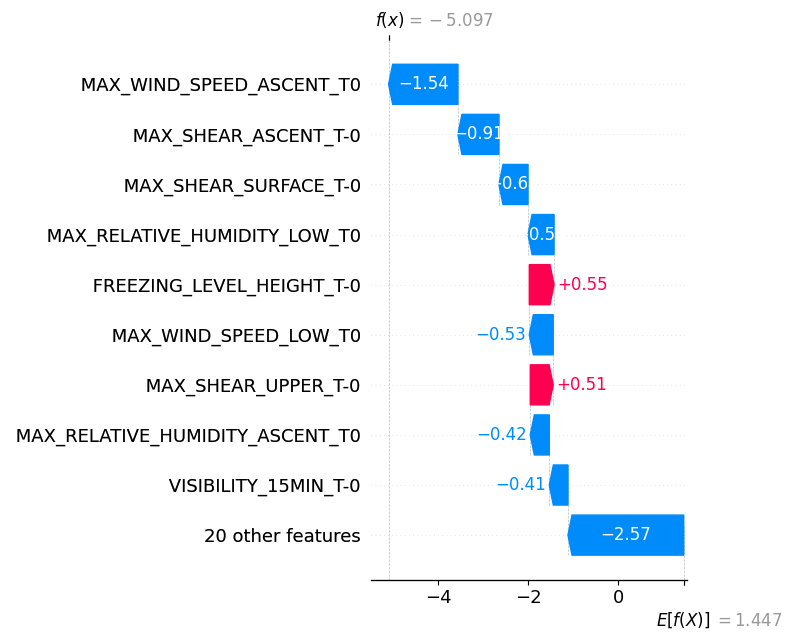

In [94]:
# Create a sample with good weather conditions
violation_sample = {
    # Shear (Float Units)
    'MAX_SHEAR_SURFACE_T-0': 0.0,            # No shear
    'MAX_SHEAR_LOW_T-0': 0.0,                # No shear
    'MAX_SHEAR_ASCENT_T-0': 0.0,             # No shear
    'MAX_SHEAR_UPPER_T-0': 0.0,              # No shear

    # Precipitation (inches)
    'PRECIPITATION_15MIN_T-0': 0.0,          # No precipitation
    'RAIN_15MIN_T-0': 0.0,                   # No rain

    # Freezing Level Height (meters)
    'FREEZING_LEVEL_HEIGHT_T-0': 10993,      # High freezing level

    # Stability Indices
    'LIFTED_INDEX_T-0': -20.0,               # Very unstable
    'CONVECTIVE_INHIBITION_T-0': 0.0,        # No inhibition
    'CAPE_15MIN_T-0': 0.0,                   # No instability

    # UV Index
    'UV_INDEX_T-0': 3.8,                     # Moderate UV

    # Weather Code & Visibility
    'WEATHER_CODE_15MIN_T-0': 1,             # Slightly adverse conditions
    'VISIBILITY_15MIN_T-0': 300000,          # Very high visibility

    # Temperature (°F)
    'MAX_TEMPERATURE_SURFACE_T0': 74.3,      # Warm temperature
    'MAX_TEMPERATURE_LOW_T0': 63.1,          # Mild conditions
    'MAX_TEMPERATURE_ASCENT_T0': 44.6,       # Cool
    'MAX_TEMPERATURE_UPPER_T0': -31.9,       # Very cold upper atmosphere

    # Wind Speed (mph)
    'MAX_WIND_SPEED_SURFACE_T0': 0,          # No wind
    'MAX_WIND_SPEED_LOW_T0': 0,              # No wind
    'MAX_WIND_SPEED_ASCENT_T0': 0,           # No wind
    'MAX_WIND_SPEED_UPPER_T0': 0,            # No wind

    # Cloud Cover (%)
    'MAX_CLOUD_COVER_SURFACE_T0': 0,         # Clear skies
    'MAX_CLOUD_COVER_LOW_T0': 0,             # Clear skies
    'MAX_CLOUD_COVER_ASCENT_T0': 0,          # Clear skies
    'MAX_CLOUD_COVER_UPPER_T0': 0,           # Clear skies

    # Relative Humidity (%)
    'MAX_RELATIVE_HUMIDITY_SURFACE_T0': 51,   # Moderate humidity
    'MAX_RELATIVE_HUMIDITY_LOW_T0': 40,       # Moderate humidity
    'MAX_RELATIVE_HUMIDITY_ASCENT_T0': 25,    # Low humidity
    'MAX_RELATIVE_HUMIDITY_UPPER_T0': 24,     # Low humidity

    # Thresholds
    # 'VISIBILITY_THRESHOLD_MET_T-0': 1
}

# Create a DataFrame with the violation sample
violation_df = pd.DataFrame([violation_sample])

# Get predictions
violation_pred = gb_predictor.predict(violation_df)
violation_proba = gb_predictor.predict_proba(violation_df)

print("\nPrediction Results for Violation Sample:")
print(f"Predicted Class: {'NOGO' if violation_pred[0] == 1 else 'GO'}")
print(f"Probability of GO: {violation_proba[0][0]:.4f}")
print(f"Probability of NOGO: {violation_proba[0][1]:.4f}")

import shap

# Create explainer
explainer = shap.TreeExplainer(gb_predictor.gb_model)

# Calculate SHAP values for the violation sample
X_scaled = gb_predictor.scaler.transform(violation_df)
shap_values = explainer.shap_values(X_scaled)

# For binary classification, we want the second class (index 1)
if isinstance(shap_values, list):
    shap_values_for_class1 = shap_values[1]
    expected_value = explainer.expected_value[1]
else:
    shap_values_for_class1 = shap_values
    expected_value = explainer.expected_value

# Create feature importance plot
print("\nFeature Importance Analysis:")
feature_names = violation_df.columns.tolist()
shap_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(shap_values_for_class1).mean(axis=0)
})
shap_importance = shap_importance.sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
for idx, row in shap_importance.head(10).iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

# Generate SHAP force plot for detailed explanation
print("\nDetailed Prediction Explanation:")
shap.initjs()
shap.force_plot(
    expected_value,
    shap_values_for_class1[0],
    violation_df.iloc[0],
    matplotlib=True,
    show=False
)

# Alternative visualization: Summary plot instead of waterfall
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_for_class1,
    violation_df,
    plot_type="bar",
    show=False
)
plt.tight_layout()
plt.show()

# If you still want to try the waterfall plot, use this alternative approach:
plt.figure(figsize=(10, 12))
shap.plots._waterfall.waterfall_legacy(
    expected_value,
    shap_values_for_class1[0],
    violation_df.iloc[0],
    feature_names=feature_names,
    show=False
)
plt.tight_layout()
plt.show()

In [89]:
print(flattened_agg_model_data.describe().to_markdown())

|       |   MAX_SHEAR_SURFACE_T-0 |   MAX_SHEAR_LOW_T-0 |   MAX_SHEAR_ASCENT_T-0 |   MAX_SHEAR_UPPER_T-0 |   PRECIPITATION_15MIN_T-0 |   RAIN_15MIN_T-0 |   FREEZING_LEVEL_HEIGHT_T-0 |   LIFTED_INDEX_T-0 |   CONVECTIVE_INHIBITION_T-0 |   CAPE_15MIN_T-0 |   UV_INDEX_T-0 |   WEATHER_CODE_15MIN_T-0 |   VISIBILITY_15MIN_T-0 |   MAX_TEMPERATURE_SURFACE_T0 |   MAX_TEMPERATURE_LOW_T0 |   MAX_TEMPERATURE_ASCENT_T0 |   MAX_TEMPERATURE_UPPER_T0 |   MAX_WIND_SPEED_SURFACE_T0 |   MAX_WIND_SPEED_LOW_T0 |   MAX_WIND_SPEED_ASCENT_T0 |   MAX_WIND_SPEED_UPPER_T0 |   MAX_CLOUD_COVER_SURFACE_T0 |   MAX_CLOUD_COVER_LOW_T0 |   MAX_CLOUD_COVER_ASCENT_T0 |   MAX_CLOUD_COVER_UPPER_T0 |   MAX_RELATIVE_HUMIDITY_SURFACE_T0 |   MAX_RELATIVE_HUMIDITY_LOW_T0 |   MAX_RELATIVE_HUMIDITY_ASCENT_T0 |   MAX_RELATIVE_HUMIDITY_UPPER_T0 |         NOGO |
|:------|------------------------:|--------------------:|-----------------------:|----------------------:|--------------------------:|-----------------:|---------------------

In [95]:
# Save both the model and scaler
import pickle
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the complete predictor object (includes both model and scaler)
print("Saving predictor object...")
predictor_filename = os.path.join('models', 'gb_predictor.pkl')
with open(predictor_filename, 'wb') as f:
    pickle.dump(gb_predictor, f)
print(f"Predictor saved as {predictor_filename}")

Saving predictor object...
Predictor saved as models/gb_predictor.pkl


In [96]:
# Save the LightGBM model
print("Saving LightGBM model...")
model_filename = os.path.join('models', 'lightgbm_model.pkl')
with open(model_filename, 'wb') as f:
    pickle.dump(gb_model, f)
print(f"LightGBM model saved as {model_filename}")



Saving LightGBM model...
LightGBM model saved as models/lightgbm_model.pkl


In [ ]:
class LSTMPredictor:
    def __init__(self, time_series_data, target_column):
        self.time_series_data = time_series_data
        self.target_column = target_column
        self.lstm_model = None
        self.scaler = StandardScaler()

    def train(self):
        """Train LSTM model using time series data for binary classification"""
        print("Preparing data for LSTM model...")

        # Get all feature columns except target
        feature_cols = [col for col in self.time_series_data.columns if col != self.target_column]

        # Prepare sequences of 3 timesteps
        sequences = []
        targets = []

        for _, row in self.time_series_data.iterrows():
            # Get feature values for last 3 timesteps
            sequence = []
            for col in feature_cols:
                values = row[col]
                if len(values) >= 3:
                    sequence.append(values[:3])

            if len(sequence) == len(feature_cols):
                sequences.append(sequence)
                targets.append(row[self.target_column])

        # Convert to numpy arrays
        X = np.array(sequences)
        y = np.array(targets)

        # Reshape to [samples, timesteps, features]
        X = X.transpose(0, 2, 1)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Scale features
        X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
        X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

        X_train_scaled = self.scaler.fit_transform(X_train_reshaped)
        X_test_scaled = self.scaler.transform(X_test_reshaped)

        # Reshape back
        X_train = X_train_scaled.reshape(X_train.shape)
        X_test = X_test_scaled.reshape(X_test.shape)

        print("Building LSTM model...")
        self.lstm_model = Sequential([
            LSTM(64, return_sequences=True, input_shape=(3, X_train.shape[-1])),
            Dropout(0.3),
            LSTM(32),
            Dropout(0.3),
            Dense(16, activation='relu'),
            Dense(1, activation='sigmoid')  # Binary classification output
        ])

        # Compile model
        self.lstm_model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        print("Training LSTM model...")
        history = self.lstm_model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            validation_split=0.2,
            callbacks=[EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            )],
            verbose=1
        )

        return history

# Usage example:
lstm_predictor = LSTMPredictor(
    time_series_data=model_data,
    target_column='NOGO'
)

# Train LSTM model
lstm_history = lstm_predictor.train()